# Perovskite growth analysis

1. Imports

## 1. Imports

In [1]:
import hyperspy.api as hs                 # hyperspectral data processing and some useful image viewing
import h5py                               # to handle .h5 files
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2                                # Image analysis
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from datetime import datetime             # For easily parsing timestamps
import warnings
warnings.filterwarnings("ignore")         # Attempt to remove some unnecessary pyplot warnings
from scipy.optimize import curve_fit
import pandas as pd
from pathlib import Path
import imageio
import scipy
import matplotlib

# Custom functions
import sys
# Some code developed by Edward Saunders during a NanoDTC mini project, available at
# https://github.com/ESaundersNano/Mini-1-Multidimensional-analysis-of-perovskite-growth
sys.path.append('Ed_code/')
import optical_image_functions as oif
import hyperspectral_image_functions as hsif

In [2]:
def get_binary(im,k_blur=15,k_close=5,k_open=19,k_sobel=25,min_rel_val=.1):
    """
    Suggested image pre-processing to produce a binary that can get good estimates of crystal area from an image. 
    @param im: a 2D float32 array
    @return binary: a 2D array of uint8 values of 1s and 0s. 
    Pre-processing can heavily influence the quality of the area estimates and should be tailored to specific sets of images.
    Use plotting functions I have made to investigate 
    Things to consider include:
        Changing the order or presence of image pre-processing operations
        Change the size of kernels from the default values suggested in optical_image_functions
        Avoid causing area values to collapse by making the edge around the crystal discontinuous
        Avoid having a binary that effectively has a shell in the outline
    Use https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html as a guide for what some of the operations do.
    Note that some of the image examples may not apply as expected depending on at which stage the operations are applied (e.g. opening base image rather than the threshold or sobel).
    """
    im1 = oif.blur_image(im,k_blur=k_blur)
    im1=oif.close_image(im1, k_close) # changing the kernel size to 8 was found to improve the end binary in this case.
    im1=oif.open_image(im1,k_open=k_open)
    im1=oif.open_image(im1,k_open=k_open)
    im1=oif.sobel_2D(im1,k_sobel=k_sobel)
    binary=oif.threshold_image(im1,minimum_rel_val=min_rel_val)
    del im1
    return binary

def extract_best_contour_data(contour_sets, area_sets, perim_sets):
    """
    Suggested function for extracting the most relevant contour data. Currently just takes the set of data belonging to the contour with the biggest area. The logic being that the largest contour is
    most likely to be around the most interesting crystal growing entirely within the view of the camera. The area was used instead of the permiter as it is more stable.
    @param contour_sets: an array containing sets of contours for each image.
    @param area_sets: an array containing sets (stored in arrays) of areas (floats) corresponding to contours identified in each image.
    @param perim_sets: an array containing sets (stored in arrays) of perimeters (floats) corresponding to contours identified in each image.
    @return best_contours, best_areas, best_perims
    
    Possible future changes:
    - Make more general so can pick out the contour of a single crystal entirely within frame despite other features of the image
    - Throw an error if this isn't possible or a single crystal isn't present
    """
    best_contours = []
    best_areas = []
    best_perims = []
    for i in np.arange(len(contour_sets)):
        criterion = np.max(area_sets[i]) # Just takes the biggest contour
        best_areas.append(criterion)
        j = area_sets[i].index(criterion)
        best_contours.append(contour_sets[i][j])
        best_perims.append(perim_sets[i][j])
    return best_contours, best_areas, best_perims

def clean_area_data(contour_series, area_series, time_series, step_factor=100,rel_dif=.5):
    """
    Suggested function for processing crystal area data before extracting growth rates. It checks if there is a large step change in the crystal being tracked. If the estimate recovers, it replaces the
    faulty data with NaN. If the estimate does not recover by the next entry, it truncates the series in the assumption that the failure is due to the crystal reaching the edge of the field of view which
    causes the contours to freak out a bit.
    @param contour_series: an array of contour data for each time step
    @param area_series: an array of area estimates (floats) for each contour
    @param time_series: an array of timestamps (floats) for each image
    @param step_factor: factor determining the sensitivity of the detector to a step change in area
    @return cleaned_contour_series, cleaned_area_series, cleaned_time_series
    
    Possible future changes:
    - Make more lenient in truncating condition. Justified for now as possible to remove problems with image pre-processing but more flexibility may be useful for larger data sets.
    """
    cleaned_area_series = []
    index_list = np.arange(len(area_series))
    NaNcounter=0 # Counter used to track how many NaNs in total
    for i in index_list:

        if i == 0 or i == index_list[-1]:
            cleaned_area_series.append(area_series[i])
        elif i == 1:
            cleaned_area_series.append(area_series[i])
        # Check if something has gone wrong with area estimate
        elif abs(area_series[i]-cleaned_area_series[0])>rel_dif*cleaned_area_series[0]:
            cleaned_area_series.append(np.NaN)
            NaNcounter += 1
        elif abs(area_series[i]-cleaned_area_series[-1]) > step_factor*abs(cleaned_area_series[-1]-cleaned_area_series[-2]):
            
#             # Check if area value collapsed probably without recovery, likely due to crystal reaching edge of frame
            
#             if area_series[i+1] < cleaned_area_series[i-1]: # Perhaps it is a bit harsh, but checks by seeing if 2 in a row a problem
#                 break
#             # If next entry is fine, replace with a NaN and move on
#             else:
                cleaned_area_series.append(np.NaN)
                NaNcounter += 1
                
        # If everything is fine, just add the area to the cleaned list
        else:
            cleaned_area_series.append(area_series[i])   
    cleaned_time_series = time_series[:len(cleaned_area_series)]
    cleaned_contour_series = contour_series[:len(cleaned_area_series)]
    print("Area entries which are dodgy:", NaNcounter)
    if NaNcounter > len(cleaned_area_series)*0.33:
            print("More than a third of area data entries in cleaned range are dodgy")
    return cleaned_contour_series, cleaned_area_series, cleaned_time_series

def plot_contours(cnts,im,title=None,ax=None):
    """ Takes contours and an image, and plots them both"""
    if ax == None:
        f,ax = plt.subplots()
    #plt.scatter(cnts[:,0][:][:,0],cnts[:,0][:][:,1],s=2,color='r')
    ax.plot(cnts[:,0][:][:,0],cnts[:,0][:][:,1],'r-')
    ax.imshow(im,cmap='gray')
    if title != None:
        ax.set_title(title,fontsize=15)
    ax.axis('off')
    
def extract_facet_positions(line_points, outline_images, pixel_size, automatic_alignment=True, crop_window_width =10):
    """
    Returns facet positions and error arrays.
    Finds the position of a facet by finding the maximum signal in a 1D signal formed from a cropped portion of the images.
    Must pass images with edges highlighted as strength of signal at edges is used to track their position. 
    Position sign convention is based on the direction set by the line points.
    
    automatic_alignment controls alignment of the crop window rather than the whole image, but helps to extract position data taken perpendicular
    to the facet. Disable if having issues.
    
    May need to adjust crop_window_width depending on proximity of facet.
    
    Should be able to see most errors once plot position with time.
        
    Possible future changes:
    - Change facet location to be more sophisticated, perhaps using peak finder to smooth out errors and handle multiple facets in one line.
    - Check for sudden jumps in position caused by facet growing out of view of crop or new facet growing in.
    - Better integration with point selection, add a check to see if line points will be rotated out of view. 
    - Investigate why sometimes facets are just predicted to have not moved at all when clearly they do depending on cross section chosne.
    """
    first_image=outline_images[0]

    # Crop to box around line (with defined min width)
    minwidth=crop_window_width
    x1,y1 = line_points[0]
    x2,y2 = line_points[1]
    xmin = np.min([x1,x2]).astype(int)
    xmax = np.max([x1,x2]).astype(int)
    ymin = np.min([y1,y2]).astype(int)
    ymax = np.max([y1,y2]).astype(int)
    cropped = first_image[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]

    # Find angle of rotation between points and apply correction
    l = line_points
    vx = l[1,0]-l[0,0]
    vy = (2048-l[1,1]) - (2048-l[0,1])
    theta = np.rad2deg(np.arctan2(vx,vy))
    rotated_image=scipy.ndimage.rotate(cropped,theta,order=1)
    alignment_angle=find_alignment(rotated_image, 0.1)
    if automatic_alignment == False:
        alignment_angle=0
    rotated_image=scipy.ndimage.rotate(cropped,theta-alignment_angle,order=1)
    
    #rotated_image, rotated_line_points, angle = oif.image_rotation_by_manual_line(first_image, line_points)
    # rotated_image,angle = rotate_im_correctly(first_image,line_points)
    # one_dim_facet, angle_adjustment = extract_line_data(image=rotated_image, crop_pixel_width=crop_window_width, auto_align=True)
    
    positions =[]
    error = []
    for outline in outline_images:
        outline = outline[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]
        
        rotated_image = scipy.ndimage.rotate(outline,theta-alignment_angle,order=1)
        onedim_facet = oif.onedimify(rotated_image)
        #onedim_facet, _ = extract_line_data(image=rotated_image, crop_pixel_width=crop_window_width, auto_align=False, alignment_angle=angle_adjustment)
        # Find position of facet in onedim
        max_signal = np.max(onedim_facet)
        position = onedim_facet.index(max_signal) # just using maximum for now
        positions.append(position)
        
        # Find error by half width at half maximum
        HM = max_signal/2
        F1 = 0
        F2 = 0
        for i in np.arange(len(onedim_facet[position:])):
            if onedim_facet[position:][i]<HM:
                F2 = i
                break
        flipped = np.flip(onedim_facet[:position+1])
        for i in np.arange(len(flipped)):
            if flipped[i]<HM:
                F1 = i
                break
        FWHM = F1 + F2
        HWHM = FWHM/2
        error.append(HWHM)
        
        
    positions = np.array(positions)
    positions -= positions[0]
    positions = pixel_size*positions
    positions = abs(positions)
    error = np.array(error)
    error = pixel_size*error
    return positions, error

def find_alignment(im, step_degree=1,arange=10):
    """
    Rotates image until maximum 1D signal is found, which shuld correspond to the largest edge being aligned with the rows of the image.
    Step degree is in degrees. Rotates through 180 rather than 90 degrees to help the consistency of how the image will be aligned.
    """
    angles = np.arange(-arange, arange, step_degree) 
    biggest_signals = []
    for angle in angles:
        rotated_image = oif.rotate_image(im, angle)
        onedim = oif.onedimify(rotated_image)
        biggest_signals.append(np.max(onedim))
    best_alignment = angles[biggest_signals.index(np.max(biggest_signals))]
    return best_alignment

## 2. Load data

In [3]:
# Define filepaths
fpath_40 = r"C:\Users\grlew\OneDrive - University of Cambridge\Cambridge\PhD\Perovskite growth\Growth data\growth_temp_40deg\221216_40deg.mp4"
fpath_50 = r"C:\Users\grlew\OneDrive - University of Cambridge\Cambridge\PhD\Perovskite growth\Growth data\growth_temp_50deg\221212_1_50deg.mp4"
fpath_60 = r"C:\Users\grlew\OneDrive - University of Cambridge\Cambridge\PhD\Perovskite growth\Growth data\growth_temp_60deg\091222_60deg.mp4"
fpath_70 = r"C:\Users\grlew\OneDrive - University of Cambridge\Cambridge\PhD\Perovskite growth\Growth data\growth_temp_70deg\221212_2_70deg.mp4"

framerate_meta = 1 # 1 frame / second (apparently?)
scale = (2714-2490) / 100 # 2.2 px / um

frames_40 = 1845
len_40 = 30.46

frames_50 = 1804
len_50 = 30.05

frames_60 = 2351
len_60 = 39.12

frames_70 = 1146
len_70 = 19.07

frames_40/len_40,frames_50/len_50,frames_60/len_60,frames_70/len_70
framerate_calc = 60 # ~60 fps assuming realtime imaging

In [4]:
# vid_40 = imageio.get_reader(fpath_40,  'ffmpeg')
# vid_50 = imageio.get_reader(fpath_50,  'ffmpeg')
# vid_60 = imageio.get_reader(fpath_60,  'ffmpeg')
vid_70 = imageio.get_reader(fpath_70,  'ffmpeg')

## 3. Split each video into 6 regions

Text(0.5, 1.0, 'Frame 632')

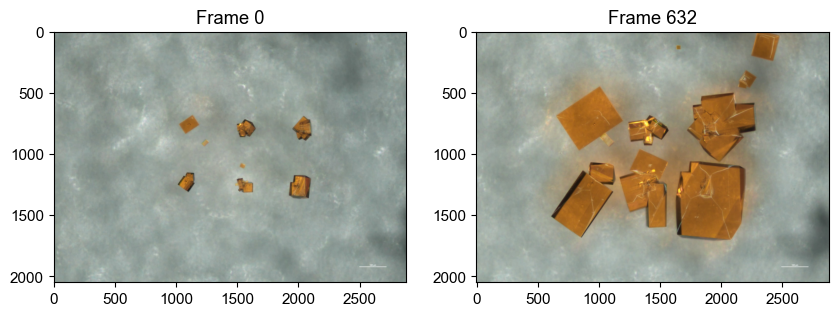

In [8]:
# Get first frame and last frame before merge

# import matplotlib
font = {'sans-serif' :'Arial',
       'size'   : 11}
matplotlib.rc('font', **font)

vid = vid_70
image_i = vid.get_data(0)
final_frame = int(10.54*60)
image_f = vid.get_data(final_frame)

f,axs = plt.subplots(ncols=2,figsize=(10,10))
axs[0].imshow(image_i)
axs[1].imshow(image_f)

axs[0].set_title('Frame 0')
axs[1].set_title('Frame %s' % final_frame)

(-0.5, 2879.5, 2047.5, -0.5)

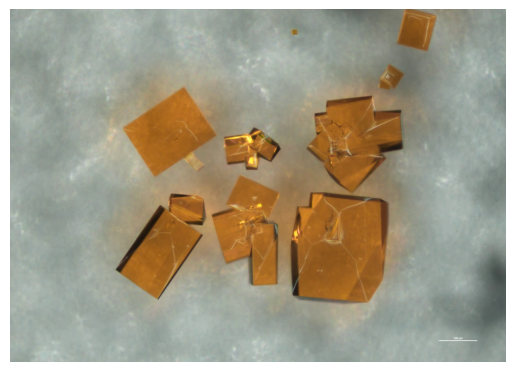

In [813]:
plt.imshow(image_f)
plt.axis('off')

In [4]:
# ROI for T=40
roi_1 = [500,1000,600,1160]
roi_2 = [500,1000,1160,1700]
roi_3 = [400,900,1700,2100]
roi_4 = [970,1500,800,1230]
roi_5 = [1000,1500,1230,1650]
roi_6 = [890,1500,1650,2200]

# ROI for T=50
roi_1 = [400,1000,800,1250]
roi_2 = [400,1000,1200,1710]
roi_3 = [600,1100,1690,2150]
roi_4 = [970,1600,800,1230]
roi_5 = [1000,1500,1230,1700]
roi_6 = [1100,1700,1600,2300]

# ROI for T=60
roi_1 = [400,900,800,1300]
roi_2 = [400,1000,1200,1710]
roi_3 = [500,1000,1690,2200]
roi_4 = [850,1400,600,1230]
roi_5 = [1000,1500,1200,1650]
roi_6 = [1050,1700,1600,2300]

# ROI for T=70
roi_1 = [400,1000,600,1250]
roi_2 = [600,1000,1200,1610]
roi_3 = [450,1100,1690,2350]
roi_4 = [970,1750,550,1200]
roi_5 = [900,1650,1130,1700]
roi_6 = [1000,1800,1600,2300]

T = 70 degrees


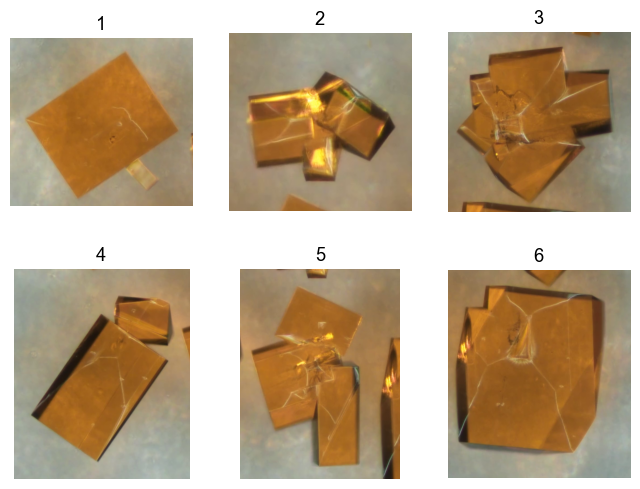

In [10]:
# Split into 6 regions of interest

# ROI = top, bottom, left, right
roi_1 = [400,1000,600,1250]
roi_2 = [600,1000,1200,1610]
roi_3 = [450,1100,1690,2350]
roi_4 = [970,1750,550,1200]
roi_5 = [900,1650,1130,1700]
roi_6 = [1000,1800,1600,2300]
rois = [roi_1,roi_2,roi_3,roi_4,roi_5,roi_6]

f, axs = plt.subplots(nrows=2,ncols=3,figsize=(8,6))

count = 0
for i in range(2):
    for j in range(3):
        roi = rois[count]
        axs[i,j].imshow(image_f[roi[0]:roi[1],roi[2]:roi[3]])
        axs[i,j].axis('off')
        axs[i,j].set_title(count+1)
        
        count+=1
        
print('T = 70 degrees')

## 4. Extract area growth rate

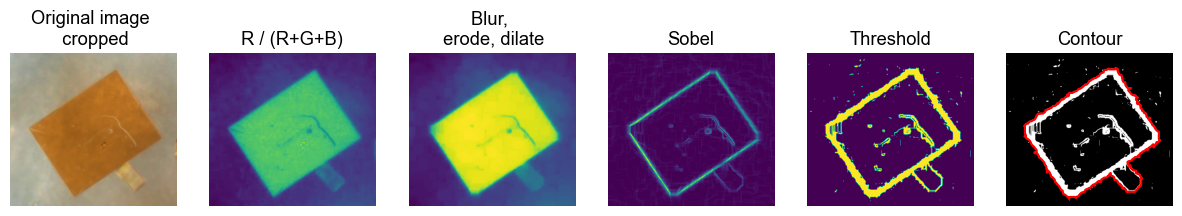

In [36]:
# Show process
import matplotlib.font_manager
# import matplotlib
# font = {'sans-serif' :'Ariel',
#        'size'   : 11}
# matplotlib.rc('font', **font)

f,axs = plt.subplots(ncols=6,figsize=(15,5))

roi = roi_1
i=600
im = vid.get_data(i)
im = im[roi[0]:roi[1],roi[2]:roi[3]]
axs[0].imshow(im)
axs[0].set_title('Original image \n cropped')
#im_bin = np.mean(im,axis=-1)
im_bin = im[:,:,0]/np.sum(im,axis=-1)
axs[1].imshow(im_bin)
axs[1].set_title('R / (R+G+B)')

k_blur=11
k_close=3
k_open=25
k_sobel=3
min_rel_val=0.07

# Blur, erode, dilate
im1 = oif.blur_image(im_bin,k_blur=k_blur)
im1=oif.close_image(im1, k_close) # changing the kernel size to 8 was found to improve the end binary in this case.
im1=oif.open_image(im1,k_open=k_open)
im1=oif.open_image(im1,k_open=k_open)

axs[2].imshow(im1)
axs[2].set_title('Blur, \n erode, dilate')


im1=oif.sobel_2D(im1,k_sobel=k_sobel)

axs[3].imshow(im1)
axs[3].set_title('Sobel')

binary=oif.threshold_image(im1,minimum_rel_val=min_rel_val)
axs[4].imshow(binary)
axs[4].set_title('Threshold')

#i=1
plot_contours(best_contours[i],binary,ax=axs[5])
axs[5].set_title('Contour')

for ax in axs:
    ax.axis('off')

# im_bin = get_binary(im_bin,k_blur=k_blur,k_close=k_close,k_open=k_open,k_sobel=k_sobel,min_rel_val=min_rel_val)
# plt.imshow(im_bin)

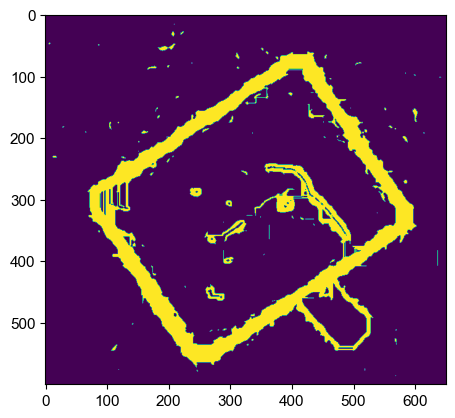

In [29]:
roi = roi_1
i=600

im = vid.get_data(i)
im = im[roi[0]:roi[1],roi[2]:roi[3]]
#im_bin = np.mean(im,axis=-1)
im_bin = im[:,:,0]/np.sum(im,axis=-1)
k_blur=11
k_close=3
k_open=25
k_sobel=3
min_rel_val=0.07
im_bin = get_binary(im_bin,k_blur=k_blur,k_close=k_close,k_open=k_open,k_sobel=k_sobel,min_rel_val=min_rel_val)
plt.imshow(im_bin)

In [30]:
# Binarise all images
bin_ims = []
for i in range(final_frame):
    # load image
    im = vid.get_data(i)
    
    # make grayscale by highlighting red channel relative increase
    im = im[:,:,0]/np.sum(im,axis=-1)
    
    # crop out area
    im = im[roi[0]:roi[1],roi[2]:roi[3]]
    
    # make binary
    im = get_binary(im,k_blur=k_blur,k_close=k_close,k_open=k_open,k_sobel=k_sobel,min_rel_val=min_rel_val)
    
    bin_ims.append(im)
    

In [31]:
# Extract contours and areas
contour_sets, area_sets, perim_sets = oif.get_contour_data(bin_ims)
ts = np.arange(final_frame)
best_contours, best_areas, best_perims = extract_best_contour_data(contour_sets, area_sets, perim_sets)
cleaned_contour_series, cleaned_area_series, cleaned_time_series = clean_area_data(best_contours, best_areas, ts,step_factor=50,rel_dif=10)

pixel_size = scale
crystal_area_series = np.array(cleaned_area_series)*pixel_size*pixel_size
crystal_time_series = cleaned_time_series
crystal_area_growth_rates = oif.extract_area_growth_rate(crystal_area_series, crystal_time_series) 

Area entries which are dodgy: 0


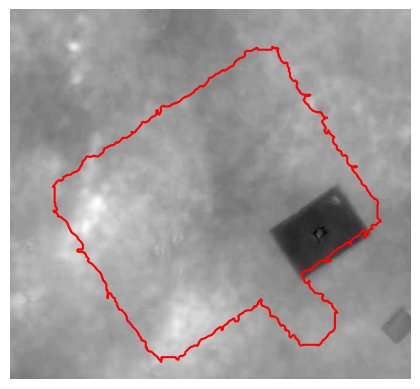

In [33]:
i=1
im = vid.get_data(i)
im = im[roi[0]:roi[1],roi[2]:roi[3]]
im = np.mean(im,axis=-1)
plot_contours(best_contours[i],im)

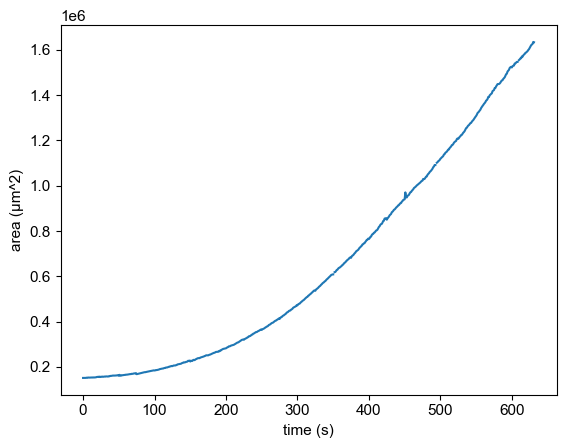

In [867]:
# Could try add to plot marker if NaN, obviously none here rn
%matplotlib inline
plt.figure()
plt.plot(crystal_time_series, crystal_area_series)
plt.xlabel("time (s)")
plt.ylabel("area (µm^2)")
plt.show()

In [838]:
crystal_1_areas = crystal_area_series

In [844]:
crystal_2_areas = crystal_area_series

In [850]:
crystal_3_areas = crystal_area_series

In [856]:
crystal_4_areas = crystal_area_series

In [862]:
crystal_5_areas = crystal_area_series

In [870]:
crystal_6_areas = crystal_area_series

In [533]:
crystal_1_all_areas = [crystal_1_areas_T40,crystal_2_areas_T40,crystal_3_areas_T40,
                     crystal_4_areas_T40,crystal_5_areas_T40,crystal_6_areas_T40]

In [572]:
np.save('crystal_1_all_areas',crystal_1_all_areas)

In [871]:
T70_all_areas = [crystal_1_areas,crystal_2_areas,crystal_3_areas,
                     crystal_4_areas,crystal_5_areas,crystal_6_areas]

In [872]:
np.save('T70_all_areas',T70_all_areas)

In [4]:
T40_areas = np.load(r'T40_all_areas.npy')
T50_areas = np.load(r'T50_all_areas.npy')
T60_areas = np.load(r'T60_all_areas.npy')
T70_areas = np.load(r'T70_all_areas.npy')

<Figure size 400x300 with 0 Axes>

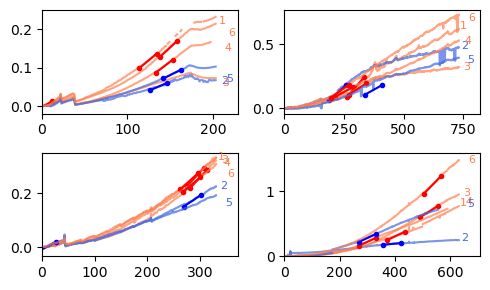

In [131]:
plt.figure(figsize=(4,3))
cs = ['coral','royalblue','coral','coral','royalblue','coral']
cs2 = ['r','b','r','r','b','r']
f,axs = plt.subplots(nrows=2,ncols=2,figsize=(5,3))

def simple_moving_average(xs,ys, windowSize):
    yhat = []
    xhat = []
    for i in range(len(xs)-windowSize):
        yhat.append(np.mean(ys[i:i+windowSize]))
        xhat.append(xs[i])
    return xhat,yhat

count = 0 
all_maxgrads = []
for j,T_areas in enumerate([T40_areas,T50_areas,T60_areas,T70_areas]):
    if count ==0:
        ii,jj = 0,0
    if count ==1:
        ii,jj = 0,1
    if count ==2:
        ii,jj = 1,0
    if count ==3:
        ii,jj = 1,1
    maxgrads = []
    for i in range(6):
        ys = T_areas[i]-T_areas[i][0]
        ys = ys/1000**2
        ts = np.arange(len(ys))
        axs[ii,jj].plot(ts,ys,label=i+1,color=cs[i],alpha=.7)
        if i == 94:
            axs[ii,jj].text(ts[-1]-70,ys[-1]-0.05,str(i+1),color=cs[i])
        elif i == 93:
            axs[ii,jj].text(ts[-1]-40,ys[-1]-0.05,str(i+1),color=cs[i])
        #     
        # elif i == 2:
        #     plt.text(ts[-1]+3,ys[-1],str('3, 4'),color=cs[i])
        # elif i ==3:
        #     continue
        # elif i == 0:
        #     plt.text(ts[-1]+3,ys[-1]-0.01,str(i+1),color=cs[i])
        else:
            axs[ii,jj].text(ts[-1]+4+i*len(ts)*0.01,ys[-1]-i*0.01,str(i+1),color=cs[i],fontsize=8)
            
        # max gradient
        grad = np.gradient(ys,axis=0)
        window = int(len(ts)*.1)
        xhat,yhat = simple_moving_average(ts,grad,window)
        yhat=np.array(yhat)
        yhat[np.where(np.isnan(yhat))]=0
        imax,maxgrad=np.argmax(yhat),np.max(yhat)
        x1,x2=imax-window/2,imax+window/2
        c=ys[imax]-maxgrad*imax
        y1,y2=maxgrad*x1+c, maxgrad*x2+c
        axs[ii,jj].plot([x1,x2],[y1,y2],'.-',color=cs2[i])
        maxgrads.append(maxgrad)
    
    count +=1
    #axs[ii,jj].set_ylim([0,.5])
    axs[ii,jj].set_xlim([0,len(ts)+len(ts)*0.12])
    all_maxgrads.append(maxgrads)
    
    
    
#plt.legend()
# plt.xlabel("Time (s)")
# plt.ylabel("Area growth (mm$^2$)")
plt.ylim([0,1.6])
# plt.xlim([-7,370])
axs[0,0].set_ylim([-0.02,0.25])
plt.tight_layout()

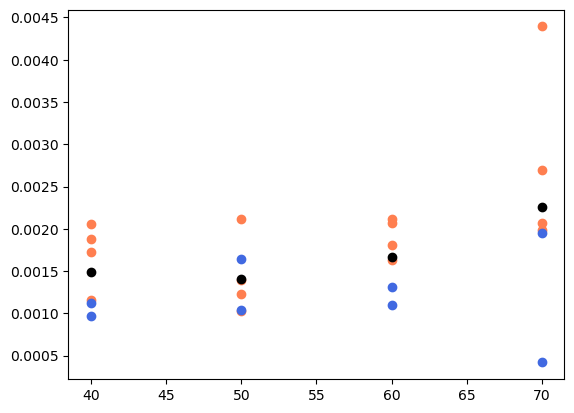

In [132]:
cs = ['coral','royalblue','coral','coral','royalblue','coral']

for i,T in enumerate([40,50,60,70]):
    for j,m in enumerate(all_maxgrads[i]):
        plt.scatter(T,m,color=cs[j])
    plt.plot(T,np.mean(all_maxgrads[i]),'ko')

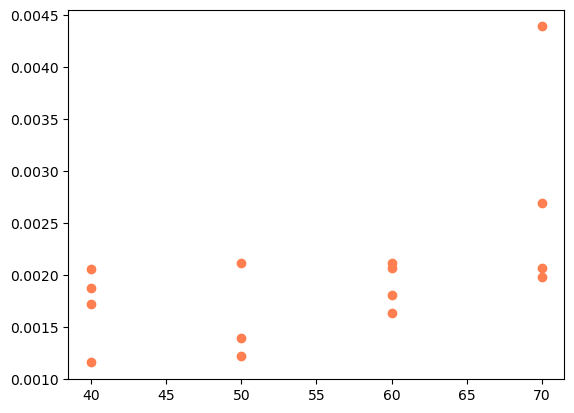

In [137]:
cs = np.array([['coral','royalblue','coral','coral','royalblue','coral'],
      ['coral','royalblue','royalblue','coral','royalblue','coral'],
      ['coral','royalblue','coral','coral','royalblue','coral'],
      ['coral','royalblue','coral','coral','royalblue','coral']])

data_free = []
for i,T in enumerate([40,50,60,70]):
    for j,m in enumerate(all_maxgrads[i]):
        if cs[i,j]=='coral':
            plt.scatter(T,m,color=cs[i,j])
            data_free.append([m,T])
    #plt.plot(T,np.mean(all_maxgrads[i]),'ko')

0.06168813814693262 0.02479355132458886


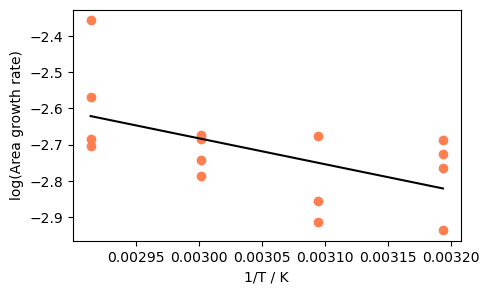

In [630]:
import scipy.optimize
def f(x, m, c): # this is your 'straight line' y=f(x)
    return m*x + c

plt.figure(figsize=(5,3))

df = pd.DataFrame(data_free)
logrates = np.log10(df.iloc[:,0])
kelvin = df.iloc[:,1] +273.15

plt.scatter(1/kelvin, logrates,color='coral') 

plt.xlabel('1/T / K')
plt.ylabel(r'log(Area growth rate)')


popt, pcov = scipy.optimize.curve_fit(f,1/kelvin,logrates)
x1,x2 = 1/kelvin[0],1/kelvin[len(kelvin)-1]
y1,y2 = popt[0]*x1+popt[1],popt[0]*x2+popt[1]
plt.plot([x1,x2],[y1,y2],'k-')

# R2 value
ydata = logrates
xdata = 1/kelvin
residuals = ydata- f(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)

# Ea calc
Ea = -popt[0]*1.380649e-23
Ea = Ea/1.6e-19 # activation energy in eV

#Ea error
p_sigma = np.sqrt(np.diag(pcov))
Ea1= -(popt[0]+p_sigma[0])*1.380649e-23/1.6e-19
err = abs(Ea-Ea1)

print(Ea,err)
# 0.06 +- 0.02 eV

In [633]:
10**f(1/(273.15+40),*popt)

0.0015093909142275778

In [157]:
popt

array([ 0.00676355, -4.93901293])

In [40]:
i=0
windowSize=10
np.mean(grad[i:i+windowSize])
ts[0]

0

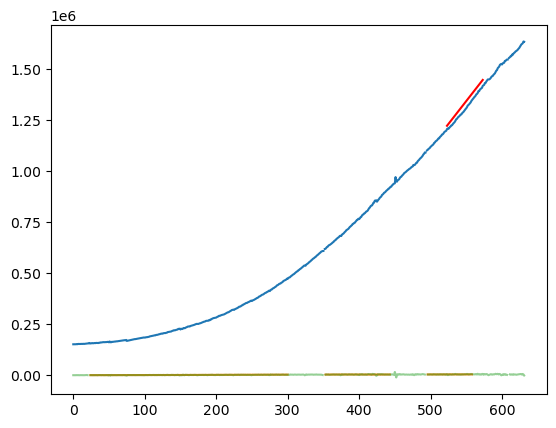

In [89]:
from scipy.signal import savgol_filter
box,order=33,3
profile = T_areas[5]
grad = np.gradient(profile,axis=0)



#plt.figure(figsize=(6,4))
window=50
xhat,yhat = simple_moving_average(ts,grad,window)
plt.plot(T_areas[5])
plt.plot(xhat,yhat)
plt.plot(ts,grad,alpha=.5)
yhat=np.array(yhat)
yhat[np.where(np.isnan(yhat))]=0
i,maxgrad=np.argmax(yhat),np.max(yhat)
plt.plot([i-window/2,i+window/2],[maxgrad*(i-window/2)-T_areas[5][i-45],maxgrad*(i+window/2)-T_areas[5][i-45]],color='r')

In [33]:
len(yhat)

624

In [21]:
np.shape(yhat[0])

()

(0.0, 1.6)

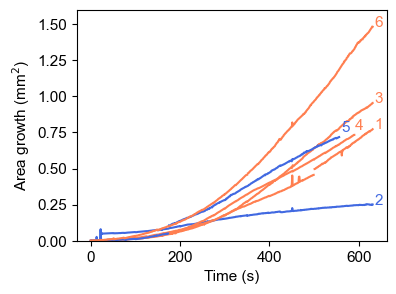

In [886]:
plt.figure(figsize=(4,3))
cs = ['coral','royalblue','coral','coral','royalblue','coral']
for i in range(6):
    ys = T70_all_areas[i]-T70_all_areas[i][0]
    ys = ys/1000**2
    plt.plot(ts,ys,label=i+1,color=cs[i])
    if i == 4:
        plt.text(ts[-1]-70,ys[-1]-0.05,str(i+1),color=cs[i])
    elif i == 3:
        plt.text(ts[-1]-40,ys[-1]-0.05,str(i+1),color=cs[i])
    #     
    # elif i == 2:
    #     plt.text(ts[-1]+3,ys[-1],str('3, 4'),color=cs[i])
    # elif i ==3:
    #     continue
    # elif i == 0:
    #     plt.text(ts[-1]+3,ys[-1]-0.01,str(i+1),color=cs[i])
    else:
        plt.text(ts[-1]+4,ys[-1],str(i+1),color=cs[i])
    
#plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Area growth (mm$^2$)")
plt.ylim([0,1.6])
# plt.xlim([-7,370])

In [902]:
T40_all_areas = np.load('T40_all_areas.npy')

(0.0, 1.6)

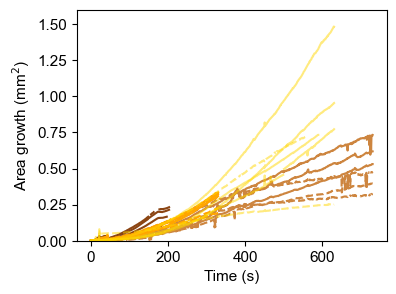

In [903]:
plt.figure(figsize=(4,3))


markers = ['-','--','--','-','--','-']

for i in range(6):
    ys = T40_all_areas[i]-T40_all_areas[i][0]
    ys = ys/1000**2
    ts = np.arange(len(ys))
    plt.plot(ts,ys,color='saddlebrown',linestyle=markers[i])

for i in range(6):
    ys = T50_all_areas[i]-T50_all_areas[i][0]
    ys = ys/1000**2
    ts = np.arange(len(ys))
    plt.plot(ts,ys,color='peru',linestyle=markers[i])

markers = ['-','--','-','-','--','-']
for i in range(6):
    ys = T60_all_areas[i]-T60_all_areas[i][0]
    ys = ys/1000**2
    ts = np.arange(len(ys))
    plt.plot(ts,ys,color='orange',linestyle=markers[i])

markers = ['-','--','-','-','--','-']
for i in range(6):
    ys = T70_all_areas[i]-T70_all_areas[i][0]
    ys = ys/1000**2
    ts = np.arange(len(ys))
    plt.plot(ts,ys,color='gold',linestyle=markers[i],alpha=.5)

plt.xlabel("Time (s)")
plt.ylabel("Area growth (mm$^2$)")
plt.ylim([0,1.6])
# plt.xlim([-7,370])

([<matplotlib.axis.XTick at 0x1ecae8266b0>,
 [Text(40, 0, '40'), Text(50, 0, '50'), Text(60, 0, '60'), Text(70, 0, '70')])

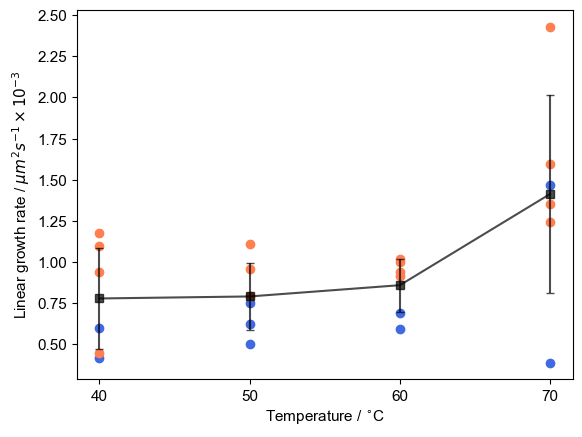

In [930]:
import scipy.optimize
def f(x, m, c): # this is your 'straight line' y=f(x)
    return m*x + c

cs = ['coral','royalblue','coral','coral','royalblue','coral']
all_ms = []
all_std = []

ms = []
for i in range(6):
    ys = T40_all_areas[i]-T40_all_areas[i][0]
    ys = ys/1000**2
    xs = np.arange(len(ys))
    
    inans = np.isnan(ys)
    yfit = ys[inans==False]
    xfit = xs[inans==False]
    
    popt, pcov = scipy.optimize.curve_fit(f,xfit,yfit)
    plt.scatter(40,popt[0]*1000,color=cs[i])
    ms.append(popt[0]*1000)

all_ms.append(np.mean(ms))
all_std.append(np.std(ms))

ms = []
cs = ['coral','royalblue','royalblue','coral','royalblue','coral']
for i in range(6):
    ys = T50_all_areas[i]-T50_all_areas[i][0]
    ys = ys/1000**2
    xs = np.arange(len(ys))
    
    inans = np.isnan(ys)
    yfit = ys[inans==False]
    xfit = xs[inans==False]
    
    popt, pcov = scipy.optimize.curve_fit(f,xfit,yfit)
    plt.scatter(50,popt[0]*1000,color=cs[i])
    ms.append(popt[0]*1000)

all_ms.append(np.mean(ms))
all_std.append(np.std(ms))

ms = []
cs = ['coral','royalblue','coral','coral','royalblue','coral']
for i in range(6):
    ys = T60_all_areas[i]-T60_all_areas[i][0]
    ys = ys/1000**2
    xs = np.arange(len(ys))
    
    inans = np.isnan(ys)
    yfit = ys[inans==False]
    xfit = xs[inans==False]
    
    popt, pcov = scipy.optimize.curve_fit(f,xfit,yfit)
    plt.scatter(60,popt[0]*1000,color=cs[i])
    ms.append(popt[0]*1000)

all_ms.append(np.mean(ms))
all_std.append(np.std(ms))

ms = []
cs = ['coral','royalblue','coral','coral','royalblue','coral']
for i in range(6):
    ys = T70_all_areas[i]-T70_all_areas[i][0]
    ys = ys/1000**2
    xs = np.arange(len(ys))
    
    inans = np.isnan(ys)
    yfit = ys[inans==False]
    xfit = xs[inans==False]
    
    popt, pcov = scipy.optimize.curve_fit(f,xfit,yfit)
    plt.scatter(70,popt[0]*1000,color=cs[i])
    ms.append(popt[0]*1000)

all_ms.append(np.mean(ms))
all_std.append(np.std(ms))

plt.errorbar([40,50,60,70],all_ms,all_std,fmt='ks-',capsize=3,alpha=.7)

plt.xlabel('Temperature / $^{\circ}$C')
plt.ylabel(r'Linear growth rate / $\mu m^2 s^{-1} \times 10^{-3}$')
plt.xticks([40,50,60,70])

## Facet analysis

### Binarise all images

Text(0.5, 1.0, 'Frame 1845')

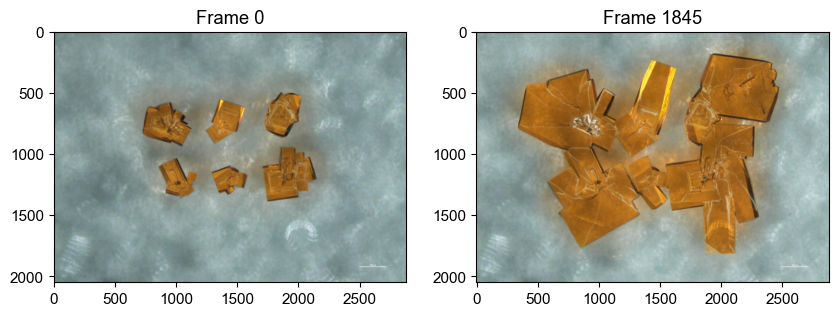

In [931]:
vid = vid_40
image_i = vid.get_data(0)
final_frame = frames_40
image_f = vid.get_data(final_frame)

f,axs = plt.subplots(ncols=2,figsize=(10,10))
axs[0].imshow(image_i)
axs[1].imshow(image_f)

axs[0].set_title('Frame 0')
axs[1].set_title('Frame %s' % final_frame)

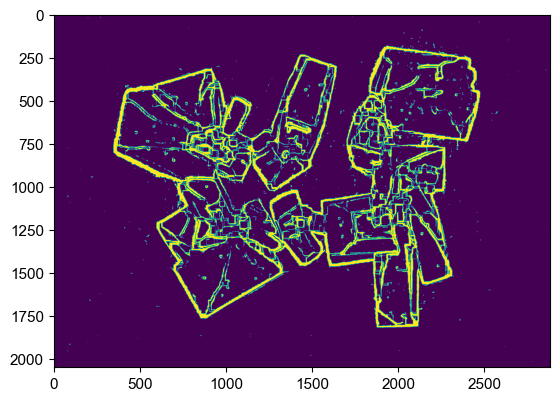

In [935]:
i = 1800
im = vid.get_data(i)
im_bin = im[:,:,0]/np.sum(im,axis=-1)
k_blur=11
k_close=3
k_open=25
k_sobel=3
min_rel_val=0.07
im_bin = get_binary(im_bin,k_blur=k_blur,k_close=k_close,k_open=k_open,k_sobel=k_sobel,min_rel_val=min_rel_val)
plt.imshow(im_bin)

In [940]:
bin_ims = []

for i in range(final_frame):
    # load image
    im = vid.get_data(i)
    
    # make grayscale by highlighting red channel relative increase
    im = im[:,:,0]/np.sum(im,axis=-1)
    
    # make binary
    im = get_binary(im,k_blur=k_blur,k_close=k_close,k_open=k_open,k_sobel=k_sobel,min_rel_val=min_rel_val)
    
    np.save('binary_ims/T40/%i'%i,im)
    del im

Text(0.5, 1.0, 'Frame 1804')

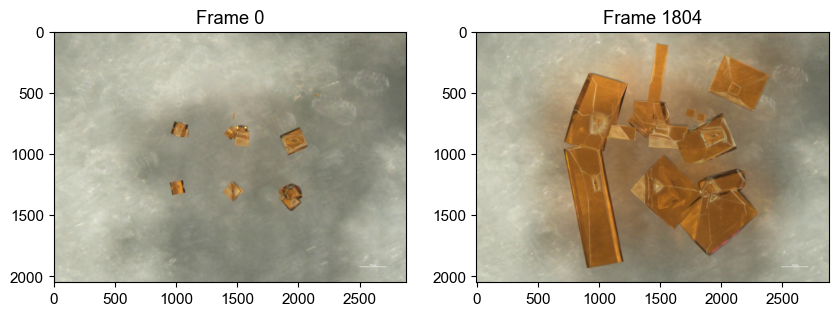

In [941]:
vid = vid_50
image_i = vid.get_data(0)
final_frame = frames_50
image_f = vid.get_data(final_frame)

f,axs = plt.subplots(ncols=2,figsize=(10,10))
axs[0].imshow(image_i)
axs[1].imshow(image_f)

axs[0].set_title('Frame 0')
axs[1].set_title('Frame %s' % final_frame)

In [942]:
bin_ims = []

for i in range(final_frame):
    # load image
    im = vid.get_data(i)
    
    # make grayscale by highlighting red channel relative increase
    im = im[:,:,0]/np.sum(im,axis=-1)
    
    # make binary
    im = get_binary(im,k_blur=k_blur,k_close=k_close,k_open=k_open,k_sobel=k_sobel,min_rel_val=min_rel_val)
    
    np.save('binary_ims/T50/%i'%i,im)
    del im

Text(0.5, 1.0, 'Frame 2351')

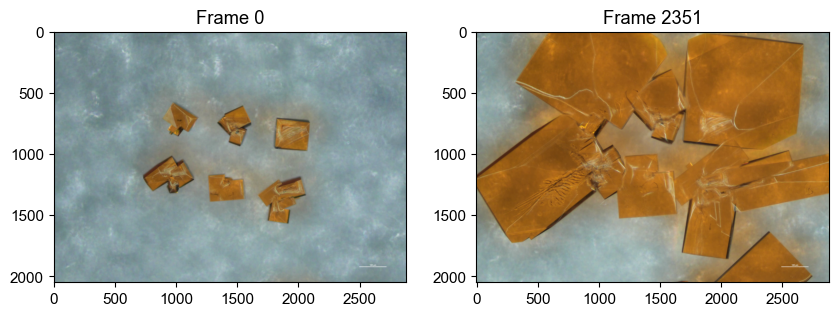

In [943]:
vid = vid_60
image_i = vid.get_data(0)
final_frame = frames_60
image_f = vid.get_data(final_frame)

f,axs = plt.subplots(ncols=2,figsize=(10,10))
axs[0].imshow(image_i)
axs[1].imshow(image_f)

axs[0].set_title('Frame 0')
axs[1].set_title('Frame %s' % final_frame)

In [944]:
bin_ims = []

for i in range(final_frame):
    # load image
    im = vid.get_data(i)
    
    # make grayscale by highlighting red channel relative increase
    im = im[:,:,0]/np.sum(im,axis=-1)
    
    # make binary
    im = get_binary(im,k_blur=k_blur,k_close=k_close,k_open=k_open,k_sobel=k_sobel,min_rel_val=min_rel_val)
    
    np.save('binary_ims/T60/%i'%i,im)
    del im

Text(0.5, 1.0, 'Frame 1146')

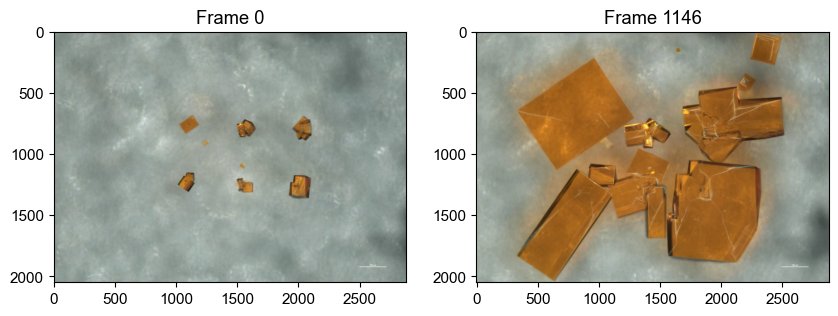

In [945]:
vid = vid_70
image_i = vid.get_data(0)
final_frame = frames_70
image_f = vid.get_data(final_frame)

f,axs = plt.subplots(ncols=2,figsize=(10,10))
axs[0].imshow(image_i)
axs[1].imshow(image_f)

axs[0].set_title('Frame 0')
axs[1].set_title('Frame %s' % final_frame)

In [946]:
bin_ims = []

for i in range(final_frame):
    # load image
    im = vid.get_data(i)
    
    # make grayscale by highlighting red channel relative increase
    im = im[:,:,0]/np.sum(im,axis=-1)
    
    # make binary
    im = get_binary(im,k_blur=k_blur,k_close=k_close,k_open=k_open,k_sobel=k_sobel,min_rel_val=min_rel_val)
    
    np.save('binary_ims/T70/%i'%i,im)
    del im

### Process binarised images

In [216]:
# Get filepaths
fpaths_T70 = oif.get_filepaths(r'binary_ims/T70/')

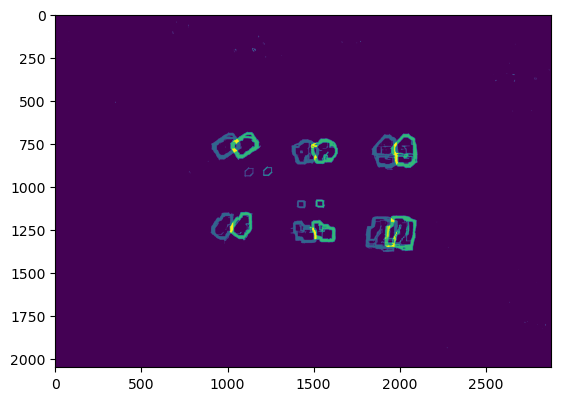

In [239]:
i=37
im = np.load(fpaths_T70[25])
im2=np.load(fpaths_T70[10])
plt.imshow(im+2*im2)

In [321]:
itest

array([  25,   34,   44,   54,   64,   74,   84,   94,  104,  114,  124,
        134,  143,  153,  163,  173,  183,  193,  203,  213,  223,  233,
        243,  252,  262,  272,  282,  292,  302,  312,  322,  332,  342,
        352,  361,  371,  381,  391,  401,  411,  421,  431,  441,  451,
        461,  471,  480,  490,  500,  510,  520,  530,  540,  550,  560,
        570,  580,  589,  599,  609,  619,  629,  639,  649,  659,  669,
        679,  689,  698,  708,  718,  728,  738,  748,  758,  768,  778,
        788,  798,  808,  817,  827,  837,  847,  857,  867,  877,  887,
        897,  907,  917,  926,  936,  946,  956,  966,  976,  986,  996,
       1006, 1016, 1026, 1035, 1045, 1055, 1065, 1075, 1085, 1095, 1105,
       1115, 1125, 1135, 1145])

In [322]:
# Load edge images - 1 every 10 seconds
tot = len(fpaths_T70)
itest = (np.linspace(25,tot-1,int(tot/10))).astype(int)
outline_images = []
for i in itest:
    im = np.load(fpaths_T70[i])
    outline_images.append(im)

In [241]:
# Initialise dataframes
df_positions = pd.DataFrame(columns=['Time','1A','1B','1C','1D','2A','2B','2C','2D','3A','3B','3C','3D',
                          '4A','4B','4C','4D','5A','5B','5C','5D','6A','6B','6C','6D'])
df_errors = pd.DataFrame(columns=['Time','1A','1B','1C','1D','2A','2B','2C','2D','3A','3B','3C','3D',
                          '4A','4B','4C','4D','5A','5B','5C','5D','6A','6B','6C','6D'])
df_points = pd.DataFrame(columns=['1A','1B','1C','1D','2A','2B','2C','2D','3A','3B','3C','3D',
                          '4A','4B','4C','4D','5A','5B','5C','5D','6A','6B','6C','6D'],index=['x1','y1','x2','y2','dist'])

In [323]:
# Add timesteps to dataframes
ts = np.arange(tot)
times = ts[itest]
df_positions['Time']=times
df_errors['Time']=times

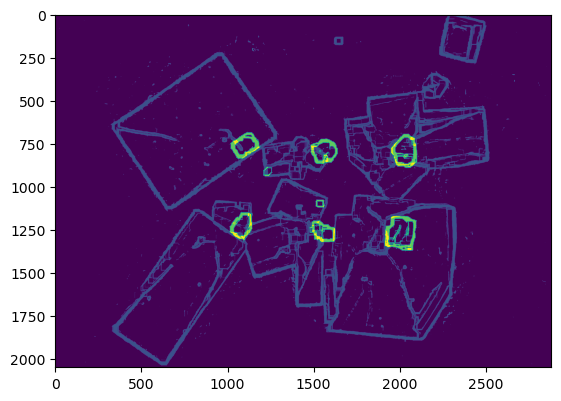

In [243]:
# Get reference image
imi = np.load(fpaths_T70[0])
imf = np.load(fpaths_T70[-1])
im_test = imi*3+imf

%matplotlib inline
plt.imshow(im_test)

In [357]:
# Choose facets

# LABEL CRYSTAL HERE
crystal='7'
%matplotlib qt
line_points_list=(oif.manual_detection(im_test,max_shapes=25))

# calculate average location of all edges
i_edge = np.where(imf!=0)
my,mx = np.mean(i_edge[0]),np.mean(i_edge[1])

dists = []
for i in range(4):
    x,y = line_points_list[i][1]
    d = ((x-mx)**2 + (y-my)**2)**0.5
    dists.append(d)

IndexError: list index out of range

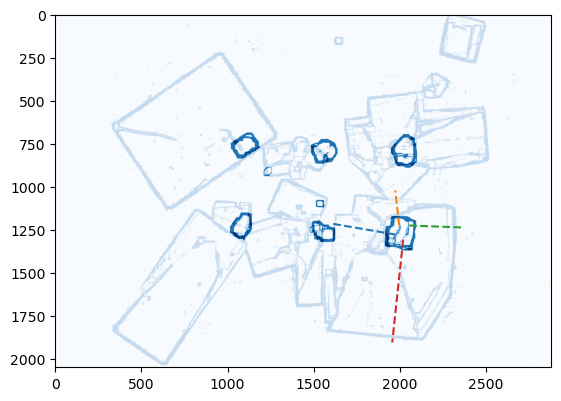

In [346]:
%matplotlib inline
plt.imshow(im_test,cmap='Blues')
for pair in line_points_list:
    plt.plot(pair[:,0],pair[:,1],'--')

In [347]:
%matplotlib inline
pixel_size=scale
# Extract growth profiles
positions_array=[]
error_array = []
for i in np.arange(len(line_points_list)):
    print(i)
    line_points=line_points_list[i]
    positions, error = extract_facet_positions(line_points, outline_images, pixel_size)#,crop_window_width=3,automatic_alignment=False)
    positions_array.append(positions)
    error_array.append(error)
positions_array=np.array(positions_array)
error_array = np.array(error_array)

0
1
2
3


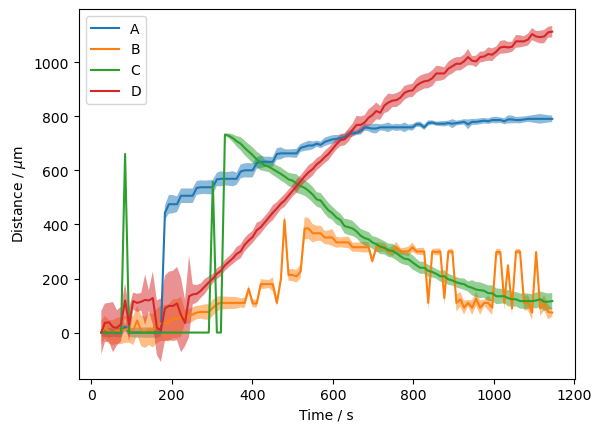

In [348]:
# Check how it looks
%matplotlib inline
labels = ['A','B','C','D']
for i,p in enumerate(positions_array):
    try:
        plt.plot(ts[itest],p,label=labels[i])
        plt.fill_between(ts[itest],p-error_array[i],p+error_array[i],alpha=.5)
    except:
        continue
        
plt.xlabel('Time / s')
plt.ylabel('Distance / $\mu$m')
plt.legend()

Text(0, 0.5, 'Distance grown of facet / px')

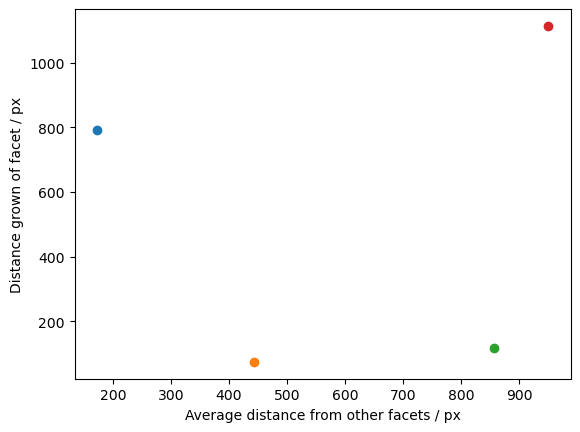

In [349]:
for i,p in enumerate(positions_array):
    plt.scatter(dists[i],p[-1])
    
plt.xlabel('Average distance from other facets / px')
plt.ylabel('Distance grown of facet / px')

In [350]:
crystal

'6'

In [351]:
# update dataframes if good results

for i,f in enumerate(['A','B','C','D']):
    df_positions[crystal+f] = positions_array[i] # Add facet position
    df_errors[crystal+f] = error_array[i] # add errors
    df_points[crystal+f].values[:4]=line_points_list[i].flatten() # add points
    df_points[crystal+f].values[4] = dists[i]

In [352]:
# save current dfs
df_positions.to_pickle(r'Facet growths/T70_positions.pkl')
df_errors.to_pickle(r'Facet growths/T70_errors.pkl')
df_points.to_pickle(r'Facet growths/T70_points.pkl')

(-0.5, 2879.5, 2047.5, -0.5)

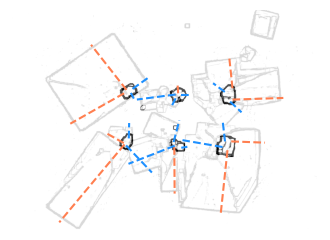

In [354]:
points_to_plot = []
plt.figure(figsize=(4,3))

outer = ['1A','1B','2B','3B','3C','4A','4D','5D','6C','6D']
#outer = ['1A','1B','2B','4A','4D','5D','6C','6D']

plt.imshow(im_test,cmap='Greys')
for c in ['1','2','3','4','5','6']:
    for i,f in enumerate(['A','B','C','D']):
        x1,y1,x2,y2,_ = df_points[c+f] 
        
        if c+f in outer:
            col = 'coral'
        else:
            col = 'dodgerblue'
            
        plt.plot([x1,x2],[y1,y2],'--',color=col)

    
plt.axis('off')
#plt.title('Selected facets from $t_0$ to $t_f$')

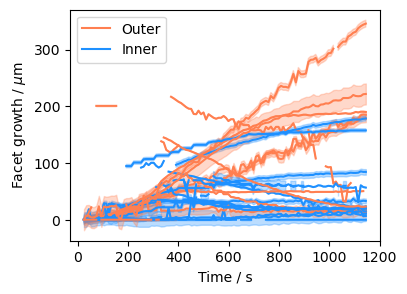

In [355]:
plt.figure(figsize=(4,3))
points_to_plot = []
ts = df_positions['Time'] 

for c in ['1','2','3','4','5','6']:
    for i,f in enumerate(['A','B','C','D']):
        ps = df_positions[c+f]/scale/scale
        es = df_errors[c+f] /scale/scale
        
        if c+f in outer:
            col = 'coral'
        else:
            col = 'dodgerblue'
            
        # Remove outliers
        for j,p in enumerate(ps):
            if j>1:
                running_avg = np.mean(ps[j-1:j])
                if abs(p-running_avg) > 30:
                    ps[j]=np.nan
                    
        plt.plot(ts,ps,label=labels[i],color=col)
        plt.fill_between(ts,ps-es[i],ps+es[i],alpha=.3,color=col)
        
plt.xlabel('Time / s')
plt.ylabel('Facet growth / $\mu$m')

plt.legend(['Outer','_nolegend_','_nolegend_','_nolegend_','Inner'])

Text(0, 0.5, 'Total facet growth / $\\mu$m')

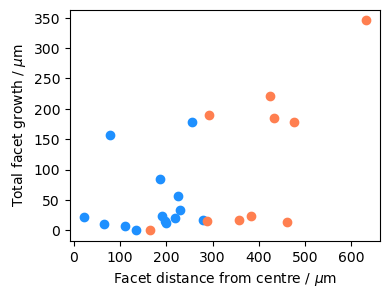

In [356]:
plt.figure(figsize=(4,3))
points_to_plot = []
ts = df_positions['Time'] 

outer = ['1A','1B','2B','3B','3C','4A','4D','5D','6C','6D']

for c in ['1','2','3','4','5','6']:
    for i,f in enumerate(['A','B','C','D']):
        ps = np.array(df_positions[c+f])/scale/scale
        dist = df_points[c+f][-1]/scale

        
        
        if c+f in outer:
            col = 'coral'
        else:
            col = 'dodgerblue'
            
        plt.scatter(dist,ps[-1],color=col)
            
#         # Remove outliers
#         for j,p in enumerate(ps):
#             if j>10:
#                 running_avg = np.mean(ps[j-10:j])
#                 if abs(p-running_avg) > 100:
#                     ps[j]=np.nan
                    
#         plt.plot(ts,ps,label=labels[i],color=col)
#         plt.fill_between(ts,ps-es[i],ps+es[i],alpha=.3,color=col)
        
plt.xlabel('Facet distance from centre / $\mu$m')
plt.ylabel('Total facet growth / $\mu$m')

# plt.legend(['Outer','_nolegend_','_nolegend_','_nolegend_','Inner'])

In [189]:
df_positions_40 = pd.read_pickle(r'Facet growths/T40_positions.pkl')
df_errors_40 = pd.read_pickle(r'Facet growths/T40_errors.pkl')
df_points_40 = pd.read_pickle(r'Facet growths/T40_points.pkl')

df_positions_50 = pd.read_pickle(r'Facet growths/T50_positions.pkl')
df_errors_50 = pd.read_pickle(r'Facet growths/T50_errors.pkl')
df_points_50 = pd.read_pickle(r'Facet growths/T50_points.pkl')

df_positions_60 = pd.read_pickle(r'Facet growths/T60_positions.pkl')
df_errors_60 = pd.read_pickle(r'Facet growths/T60_errors.pkl')
df_points_60 = pd.read_pickle(r'Facet growths/T60_points.pkl')

df_positions_70 = pd.read_pickle(r'Facet growths/T70_positions.pkl')
df_errors_70 = pd.read_pickle(r'Facet growths/T70_errors.pkl')
df_points_70 = pd.read_pickle(r'Facet growths/T70_points.pkl')

In [464]:
df_positions_40.to_csv(r'Facet growths/T40_positions.csv')
df_errors_40.to_csv(r'Facet growths/T40_errors.csv')
df_points_40.to_csv(r'Facet growths/T40_points.csv')

df_positions_50.to_csv(r'Facet growths/T50_positions.csv')
df_errors_50.to_csv(r'Facet growths/T50_errors.csv')
df_points_50.to_csv(r'Facet growths/T50_points.csv')

df_positions_60.to_csv(r'Facet growths/T60_positions.csv')
df_errors_60.to_csv(r'Facet growths/T60_errors.csv')
df_points_60.to_csv(r'Facet growths/T60_points.csv')

df_positions_70.to_csv(r'Facet growths/T70_positions.csv')
df_errors_70.to_csv(r'Facet growths/T70_errors.csv')
df_points_70.to_csv(r'Facet growths/T70_points.csv')

<Figure size 400x300 with 0 Axes>

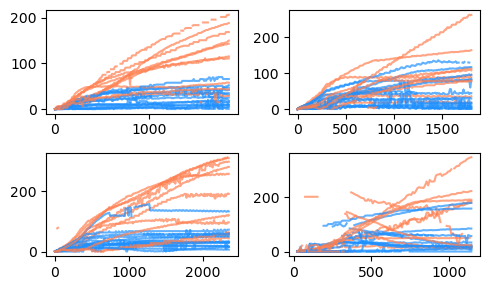

In [304]:
plt.figure(figsize=(4,3))
cs = ['coral','royalblue','coral','coral','royalblue','coral']
cs2 = ['r','b','r','r','b','r']
f,axs = plt.subplots(nrows=2,ncols=2,figsize=(5,3))

def simple_moving_average(xs,ys, windowSize):
    yhat = []
    xhat = []
    for i in range(len(xs)-windowSize):
        yhat.append(np.mean(ys[i:i+windowSize]))
        xhat.append(xs[i])
    return xhat,yhat

count = 0 
all_maxgrads = []
for j,df_positions in enumerate([df_positions_40,df_positions_50,df_positions_60,df_positions_70]):
    if count ==0:
        ii,jj = 0,0
    if count ==1:
        ii,jj = 0,1
    if count ==2:
        ii,jj = 1,0
    if count ==3:
        ii,jj = 1,1
    maxgrads = []

    ts = df_positions['Time'] 
    ts=np.array(ts)
    ts = ts[:]
    for c in ['1','2','3','4','5','6']:
        for i,f in enumerate(['A','B','C','D']):
            #try:
                ps = df_positions[str(c)+str(f)]/scale/scale
                ps = ps[:]
                # Remove outliers
                for k,p in enumerate(ps):
                    if k>1:
                        running_avg = np.mean(ps[k-1:k])
                        if abs(p-running_avg) > 30:
                            ps[k]=np.nan

                ys = ps#T_areas[i]-T_areas[i][0]
                ys = np.array(ys)
                
                color='dodgerblue'
                if c+f in outer:
                    color='coral'

                axs[ii,jj].plot(ts,ys,label=i+1,color=color,alpha=.7)


                # max gradient
#                 ts2,ys = simple_moving_average(ts,ys,20)
                
#                 grad = np.gradient(ys,axis=0)

#                 xhat,yhat = simple_moving_average(ts2,grad,5)
#                 yhat=np.array(yhat)
#                 yhat[np.where(np.isnan(yhat))]=0
#                 imax,maxgrad=np.argmax(yhat),np.max(yhat)
                
#                 x1,x2=xhat[int(imax-window/2)],xhat[int(imax+window/2)]
#                 intercept=ys[imax]-maxgrad*ts2[imax]
#                 y1,y2=maxgrad*x1+intercept, maxgrad*x2+intercept
#                 axs[ii,jj].plot([x1,x2],[y1,y2],'.-',color=cs2[i])
#                 maxgrads.append(maxgrad)
#             except:
#                 pass
    
    count +=1
    #axs[ii,jj].set_ylim([0,500])
    #axs[ii,jj].set_xlim([0,len(ts)+len(ts)*0.12])
    all_maxgrads.append(maxgrads)
    
    
    
#plt.legend()
# plt.xlabel("Time (s)")
# plt.ylabel("Area growth (mm$^2$)")
#plt.ylim([0,1.6])
# plt.xlim([-7,370])
#axs[0,0].set_ylim([-0.02,0.25])
plt.tight_layout()

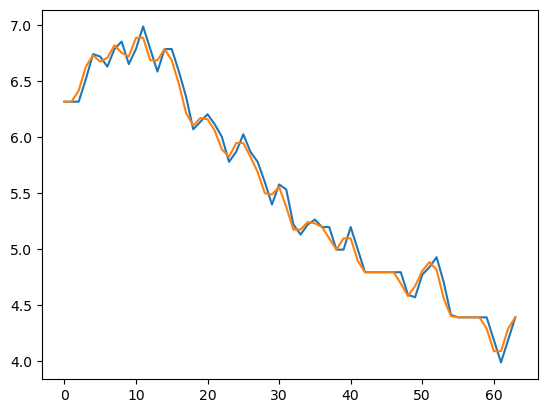

In [282]:
ps_smooth = simple_moving_average(ts,df_positions_40.iloc[:,1],50)[1]
#plt.plot(ps_smooth)
grad = np.gradient(ps_smooth)
plt.plot(grad)
grad_smooth = simple_moving_average(ts,grad,2)[1]
plt.plot(grad_smooth)

In [372]:
dx

783

4.712765957446808

In [347]:
scale

2.24

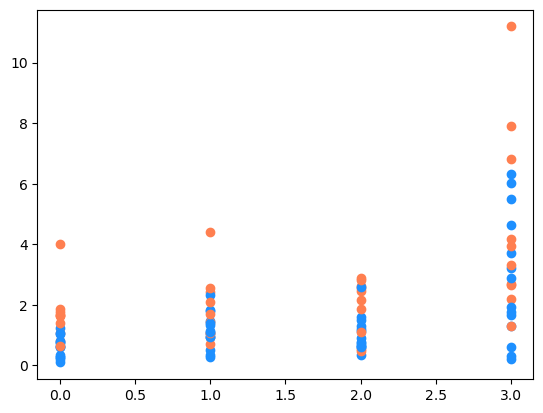

In [298]:
outer = ['1A','1B','2B','3B','3C','4A','4D','5D','6C','6D']
Ts = [40,50,60,70]
all_data = []
for j,df_positions in enumerate([df_positions_40,df_positions_50,df_positions_60,df_positions_70]):
    for c in ['1','2','3','4','5','6']:
        for i,f in enumerate(['A','B','C','D']):
            ps = df_positions[str(c)+str(f)]/scale/scale
            ts = df_positions['Time']
            
            for k,p in enumerate(ps):
                    if k>1:
                        running_avg = np.mean(ps[k-1:k])
                        if abs(p-running_avg) > 30:
                            ps[k]=np.nan
            
            xhat,yhat = simple_moving_average(ts,ps,20)
            
            #plt.plot(xhat,yhat,'k-',alpha=.5)
            grad = np.gradient(yhat,axis=0)
            xs1,ys1=simple_moving_average(xhat,grad,3)
            color='dodgerblue'
            if c+f in outer:
                color='coral'
                
            plt.scatter(j,np.max(ys1),color=color)
            all_data.append([np.max(ys1),Ts[j]])

In [368]:
all_data

array([[1.15589106e-01, 4.00000000e+01],
       [9.04634781e-02, 4.00000000e+01],
       [8.67899767e-02, 4.00000000e+01],
       [9.26507538e-02, 4.00000000e+01],
       [1.12336235e-01, 4.00000000e+01],
       [3.67910983e-02, 4.00000000e+01],
       [9.13608220e-02, 4.00000000e+01],
       [4.75872667e-02, 4.00000000e+01],
       [3.62302584e-02, 4.00000000e+01],
       [1.49379711e-01, 4.00000000e+01],
       [5.94957323e-02, 5.00000000e+01],
       [1.55323450e-01, 5.00000000e+01],
       [8.93137916e-02, 5.00000000e+01],
       [3.05761456e-02, 5.00000000e+01],
       [2.02998652e-02, 5.00000000e+01],
       [5.70249326e-02, 5.00000000e+01],
       [1.33002022e-01, 5.00000000e+01],
       [5.28694969e-02, 5.00000000e+01],
       [7.28638153e-02, 5.00000000e+01],
       [9.60242588e-02, 5.00000000e+01],
       [1.41050036e-01, 6.00000000e+01],
       [1.68588242e-01, 6.00000000e+01],
       [1.04710863e-01, 6.00000000e+01],
       [1.79556611e-01, 6.00000000e+01],
       [1.169271

0.06275146908616461 0.022145827673051066
0.3486486791588893


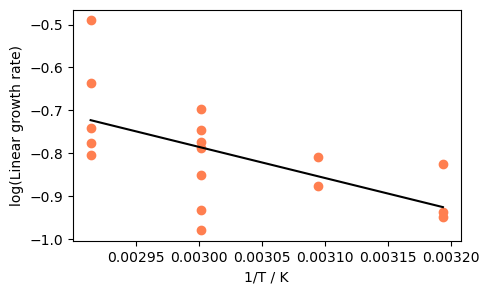

In [628]:
import scipy.optimize
def f(x, m, c): # this is your 'straight line' y=f(x)
    return m*x + c

plt.figure(figsize=(5,3))

df = pd.DataFrame(all_data)
logrates = np.log10(df.iloc[:,0])
kelvin = df.iloc[:,1] +273.15

plt.scatter(1/kelvin, logrates,color='coral') 

plt.xlabel('1/T / K')
plt.ylabel(r'log(Linear growth rate)')


popt, pcov = scipy.optimize.curve_fit(f,1/kelvin,logrates)
x1,x2 = 1/kelvin[0],1/kelvin[len(kelvin)-1]
y1,y2 = popt[0]*x1+popt[1],popt[0]*x2+popt[1]
plt.plot([x1,x2],[y1,y2],'k-')

# R2 value
ydata = logrates
xdata = 1/kelvin
residuals = ydata- f(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)

# Ea calc
Ea = -popt[0]*1.380649e-23
Ea = Ea/1.6e-19 # activation energy in eV

#Ea error
p_sigma = np.sqrt(np.diag(pcov))
Ea1= -(popt[0]+p_sigma[0])*1.380649e-23/1.6e-19
err = abs(Ea-Ea1)

print(Ea,err)
# 0.06 +- 0.02 eV
#0.14 +- 0.03
print(r_squared)

In [629]:
10**f(1/(273.15+40),*popt)

0.11855811093641548

In [636]:
popt2=popt+p_sigma
10**f(1/(273.15+40),*popt2)

0.09389727515005124

In [638]:
0.11855-0.09389
# 0.12 +- 0.02

0.02466

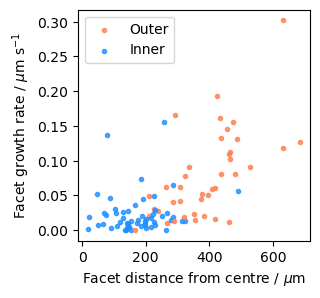

In [408]:
plt.figure(figsize=(3,3))
points_to_plot = []
ts = df_positions['Time'] 

outer = ['1A','1B','2B','3B','3C','4A','4D','5D','6C','6D']

all_positions = [df_positions_40,df_positions_50,df_positions_60,df_positions_70]
all_points = [df_points_40,df_points_50,df_points_60,df_points_70]
rs = []
ds = []
rs2 = []
ds2 = []
for temp in range(4):
    df_positions = all_positions[temp]
    df_points = all_points[temp]
    for c in ['1','2','3','4','5','6']:
        for i,f in enumerate(['A','B','C','D']):
            ps = np.array(df_positions[c+f])/scale/scale
            dist = df_points[c+f][-1]/scale
            
            # make it a rate
            ps = ps/df_positions['Time'].iloc[-1]
            
            if c+f in outer:
                col = 'coral'
                rs2.append(ps[-1])
                ds2.append(dist)
            else:
                col = 'dodgerblue'
                rs.append(ps[-1])
                ds.append(dist)

            plt.scatter(dist,ps[-1],color=col,alpha=.8,marker='.')
            # rs.append(ps[-1])
            # ds.append(dist)

        
plt.xlabel('Facet distance from centre / $\mu$m')
plt.ylabel('Facet growth rate / $\mu$m s$^{-1}$')
#plt.title('All temperatures')

plt.legend(['Outer','_nolegend_','_nolegend_','_nolegend_','Inner'])

In [404]:
def f(x, m, c): # this is your 'straight line' y=f(x)
    return m*x + c

popt, pcov = scipy.optimize.curve_fit(f,ds,rs)

# R2 value
ydata = np.array(rs)
xdata = np.array(ds)
residuals = ydata- f(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

0.015358611109726694

In [410]:
def f(x, m, c): # this is your 'straight line' y=f(x)
    return m*x + c
popt2, pcov2 = scipy.optimize.curve_fit(f,ds2,rs2)

# R2 value
ydata2 = np.array(rs2)
xdata2 = np.array(ds2)
residuals = ydata2- f(xdata2, *popt2)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata2-np.mean(ydata2))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

0.3906976617890059

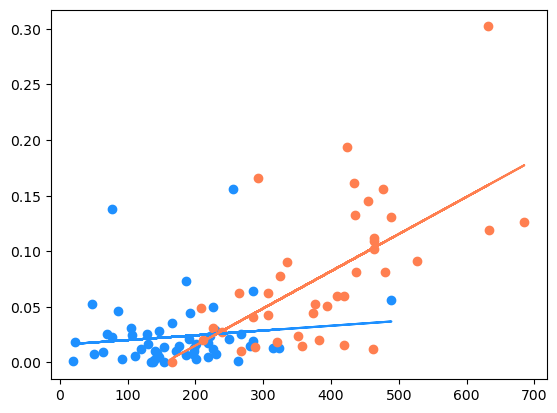

In [412]:
plt.plot(ds,f(xdata, *popt),'-',color='dodgerblue')
plt.scatter(ds,rs,color='dodgerblue')

plt.plot(ds2,f(xdata2, *popt2),'-',color='coral')
plt.scatter(ds2,rs2,color='coral')

In [377]:
df_positions['Time'].iloc[-1]

1145

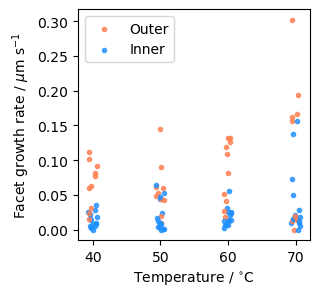

In [383]:
plt.figure(figsize=(3,3))
points_to_plot = []
ts = df_positions['Time'] 

outer = ['1A','1B','2B','3B','3C','4A','4D','5D','6C','6D']

all_positions = [df_positions_40,df_positions_50,df_positions_60,df_positions_70]
all_points = [df_points_40,df_points_50,df_points_60,df_points_70]
temps = [40,50,60,70]

for temp in range(4):
    df_positions = all_positions[temp]
    T = temps[temp]
    for c in ['1','2','3','4','5','6']:
        for i,f in enumerate(['A','B','C','D']):
            ps = np.array(df_positions[c+f])/scale/scale
            dist = df_points[c+f][-1]/scale
            
            # make it a rate
            ps = ps/df_positions['Time'].iloc[-1]
            
            if c+f in outer:
                col = 'coral'
            else:
                col = 'dodgerblue'

            plt.scatter(T+(np.random.rand(1)-.5)*1.3,ps[-1],color=col,alpha=.8,marker='.')

        
plt.xlabel(r'Temperature / $^{\circ}$C')
plt.ylabel('Facet growth rate / $\mu$m s$^{-1}$')

plt.xticks([40,50,60,70])

plt.legend(['Outer','_nolegend_','_nolegend_','_nolegend_','Inner'])

In [477]:
T40_areas = np.load('T40_all_areas.npy')
T50_areas = np.load('T50_all_areas.npy')
T60_areas = np.load('T60_all_areas.npy')
T70_areas = np.load('T70_all_areas.npy')

In [479]:
df40 = pd.re

(6, 204)

In [480]:
np.savetxt('T40_all_areas.csv',T40_areas)
np.savetxt('T50_all_areas.csv',T50_areas)
np.savetxt('T60_all_areas.csv',T60_areas)
np.savetxt('T70_all_areas.csv',T70_areas)

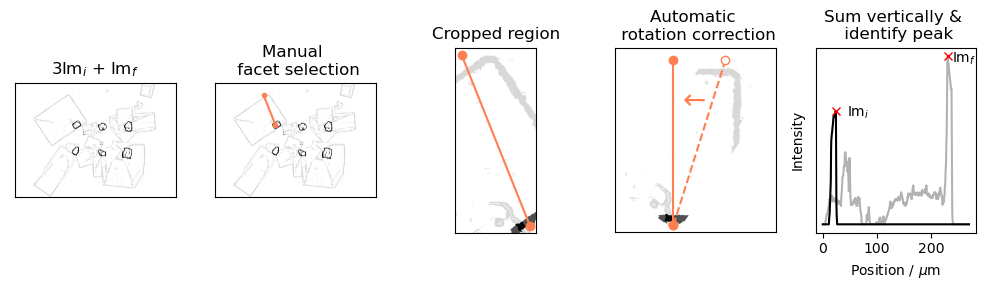

In [462]:
# Show process
import matplotlib.font_manager
%matplotlib inline

f,axs = plt.subplots(ncols=5,figsize=(10,3))

imtest=imi*3+imf
axs[0].imshow(imi*3+imf,cmap='Greys')
axs[0].set_title('3Im$_i$ + Im$_f$')

axs[1].imshow(imi*3+imf,cmap='Greys')
l = line_points_list[0]
axs[1].plot([l[0,0],l[1,0]],[l[0,1],l[1,1]],'.-', color='coral')
axs[1].set_title('Manual \n facet selection')

line_points = l
minwidth=20
x1,y1 = line_points[0]
x2,y2 = line_points[1]
xmin = np.min([x1,x2]).astype(int)
xmax = np.max([x1,x2]).astype(int)
ymin = np.min([y1,y2]).astype(int)
ymax = np.max([y1,y2]).astype(int)
cropped = imtest[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]
cropped2 = imi[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]
cropped3 = imf[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]
axs[2].plot([l[0,0]-xmin+minwidth,l[1,0]-xmin+minwidth],[l[0,1]-ymin+minwidth,l[1,1]-ymin+minwidth],'o-', color='coral')
axs[2].imshow(cropped,cmap='Greys')
axs[2].set_title('Cropped region')

l = line_points
vx = l[1,0]-l[0,0]
vy = (2048-l[1,1]) - (2048-l[0,1])
theta = np.rad2deg(np.arctan2(vx,vy))
rotated_image=scipy.ndimage.rotate(cropped,theta,order=1)
rotated_image=scipy.ndimage.rotate(cropped,-35,order=1)
rotated_image2=scipy.ndimage.rotate(cropped2,-35,order=1)
rotated_image3=scipy.ndimage.rotate(cropped3,-35,order=1)
axs[3].imshow(rotated_image,cmap='Greys')
axs[3].plot((190,360),(580,40),'o--', color='coral',markerfacecolor='w')
axs[3].plot((190,190),(580,40),'o-', color='coral')
axs[3].text(220,200,'←',color='coral',fontsize=20)
axs[3].set_title('Automatic \n rotation correction')


onedim_facet = oif.onedimify(rotated_image)
onedim_facet2 = oif.onedimify(rotated_image2)
onedim_facet3 = oif.onedimify(rotated_image3)
max_signal = np.max(onedim_facet)
position = onedim_facet.index(max_signal) # just using maximum for now
max_signal2 = np.max(onedim_facet2[::-1])
position2 = onedim_facet2[::-1].index(max_signal2)
max_signal3 = np.max(onedim_facet3[::-1])
position3 = onedim_facet3[::-1].index(max_signal3)

# Find error by half width at half maximum
HM = max_signal/2
F1 = 0
F2 = 0
for i in np.arange(len(onedim_facet[position:])):
    if onedim_facet[position:][i]<HM:
        F2 = i
        break
flipped = np.flip(onedim_facet[:position+1])
for i in np.arange(len(flipped)):
    if flipped[i]<HM:
        F1 = i
        break
FWHM = F1 + F2
HWHM = FWHM/2

position2/=scale
position3/=scale


axs[4].plot(np.arange(len(onedim_facet))/scale,onedim_facet2[::-1],color='k')
axs[4].plot(np.arange(len(onedim_facet))/scale,onedim_facet3[::-1],color='k',alpha=.3)
axs[4].plot(position2,max_signal2,'rx')
axs[4].text(position2+20,max_signal2-.01,'Im$_i$')
axs[4].plot(position3,max_signal3,'rx')
axs[4].text(position3+8,max_signal3-.01,'Im$_f$')
axs[4].set_title('Sum vertically & \n identify peak')
axs[4].set_xlabel('Position / $\mu$m')
axs[4].set_ylabel('Intensity')
axs[4].set_yticks([])

# axs[5].set_title('Contour')

for ax in axs[:-1]:
    ax.set_xticks([])
    ax.set_yticks([])

# im_bin = get_binary(im_bin,k_blur=k_blur,k_close=k_close,k_open=k_open,k_sobel=k_sobel,min_rel_val=min_rel_val)
# plt.imshow(im_bin)
plt.tight_layout()

In [1282]:
def extract_line_data(image, crop_pixel_width =50, auto_align=False, alignment_angle=0,minwidth=50):
    """
    Given an image and a pair of line points, will extract a 1D signal by cropping the image around those points and using onedimify.
    Image and line points should be rotated to align the line with the vertical by using image_rotation_by_manual line before use, as is done in 
    the function extract_facet_positions.
    Auto_align can be enabled which doesn't perform this primary rotation with the vertical, but adjusts the angle of the cropped image so that the
    1D data is taken perpendicular to the facet face being tracked.
    """
    # round line points to nearest integer for indexing
    # line_points=np.rint(line_points)
    # line_points=line_points.astype(int)
    # # define crop coordinates
    # x_pixel=line_points[0][0]
    # y_pixel_0=line_points[0][1]
    # y_pixel_1=line_points[1][1]
    # crop
    cropped = image
#     ### new
#     x1,y1 = line_points[0]
#     x2,y2 = line_points[1]
    
#     xmin = np.min([x1,x2])
#     xmax = np.max([x1,x2])
    
#     ymin = np.min([y1,y2])
#     ymax = np.max([y1,y2])
#     ###
    
#     #cropped=image[y_pixel_1-minwidth:y_pixel_0+minwidth, x_pixel-(crop_pixel_width):x_pixel+(crop_pixel_width)] #way rotation works means should always be in the right order due to direction of arrow
#     cropped = image[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]
    # alignment to force perpendicular tracking
    #print(np.shape(cropped))
    #plt.imshow(cropped)
    if auto_align==True:
        alignment_angle=oif.find_alignment(cropped, 0.1)
    
    cropped=oif.rotate_image(cropped, alignment_angle)
    
    return oif.onedimify(cropped), alignment_angle

def extract_facet_positions(line_points, outline_images, pixel_size, automatic_alignment=True, crop_window_width =50):
    """
    Returns facet positions and error arrays.
    Finds the position of a facet by finding the maximum signal in a 1D signal formed from a cropped portion of the images.
    Must pass images with edges highlighted as strength of signal at edges is used to track their position. 
    Position sign convention is based on the direction set by the line points.
    
    automatic_alignment controls alignment of the crop window rather than the whole image, but helps to extract position data taken perpendicular
    to the facet. Disable if having issues.
    
    May need to adjust crop_window_width depending on proximity of facet.
    
    Should be able to see most errors once plot position with time.
        
    Possible future changes:
    - Change facet location to be more sophisticated, perhaps using peak finder to smooth out errors and handle multiple facets in one line.
    - Check for sudden jumps in position caused by facet growing out of view of crop or new facet growing in.
    - Better integration with point selection, add a check to see if line points will be rotated out of view. 
    - Investigate why sometimes facets are just predicted to have not moved at all when clearly they do depending on cross section chosne.
    """
    first_image=outline_images[0]
    
    x1,y1 = line_points[0]
    x2,y2 = line_points[1]
    
    xmin = np.min([x1,x2]).astype(int)
    xmax = np.max([x1,x2]).astype(int)

    ymin = np.min([y1,y2]).astype(int)
    ymax = np.max([y1,y2]).astype(int)
    
    first_image = first_image[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]
    
    #rotated_image, rotated_line_points, angle = oif.image_rotation_by_manual_line(first_image, line_points)
    rotated_image,angle = rotate_im_correctly(first_image,line_points)
    one_dim_facet, angle_adjustment = extract_line_data(image=rotated_image, crop_pixel_width=crop_window_width, auto_align=True)
    
    positions =[]
    error = []
    for outline in outline_images:
        outline = outline[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]
        
        rotated_image = oif.rotate_image(outline, angle)
        onedim_facet, _ = extract_line_data(image=rotated_image, crop_pixel_width=crop_window_width, auto_align=False, alignment_angle=angle_adjustment)
        # Find position of facet in onedim
        max_signal = np.max(onedim_facet)
        position = onedim_facet.index(max_signal) # just using maximum for now
        positions.append(position)
        
        # Find error by half width at half maximum
        HM = max_signal/2
        F1 = 0
        F2 = 0
        for i in np.arange(len(onedim_facet[position:])):
            if onedim_facet[position:][i]<HM:
                F2 = i
                break
        flipped = np.flip(onedim_facet[:position+1])
        for i in np.arange(len(flipped)):
            if flipped[i]<HM:
                F1 = i
                break
        FWHM = F1 + F2
        HWHM = FWHM/2
        error.append(HWHM)
        
        
    positions = np.array(positions)
    positions -= positions[0]
    positions = pixel_size*positions
    positions = abs(positions)
    error = np.array(error)
    error = pixel_size*error
    return positions, error

def rotate_im_correctly(im,points):
    l=points
    vx = l[1,0]-l[0,0]
    vy = (2048-l[1,1]) - (2048-l[0,1])
    theta = np.rad2deg(np.arctan2(vx,vy))
    imrot = scipy.ndimage.rotate(im,theta)
    return imrot, theta



In [1325]:
def extract_facet_positions(line_points, outline_images, pixel_size, automatic_alignment=True, crop_window_width =50):
    """
    Returns facet positions and error arrays.
    Finds the position of a facet by finding the maximum signal in a 1D signal formed from a cropped portion of the images.
    Must pass images with edges highlighted as strength of signal at edges is used to track their position. 
    Position sign convention is based on the direction set by the line points.
    
    automatic_alignment controls alignment of the crop window rather than the whole image, but helps to extract position data taken perpendicular
    to the facet. Disable if having issues.
    
    May need to adjust crop_window_width depending on proximity of facet.
    
    Should be able to see most errors once plot position with time.
        
    Possible future changes:
    - Change facet location to be more sophisticated, perhaps using peak finder to smooth out errors and handle multiple facets in one line.
    - Check for sudden jumps in position caused by facet growing out of view of crop or new facet growing in.
    - Better integration with point selection, add a check to see if line points will be rotated out of view. 
    - Investigate why sometimes facets are just predicted to have not moved at all when clearly they do depending on cross section chosne.
    """
    first_image=outline_images[0]

    # Crop to box around line (with defined min width)
    minwidth=10
    x1,y1 = line_points[0]
    x2,y2 = line_points[1]
    xmin = np.min([x1,x2]).astype(int)
    xmax = np.max([x1,x2]).astype(int)
    ymin = np.min([y1,y2]).astype(int)
    ymax = np.max([y1,y2]).astype(int)
    cropped = first_image[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]

    # Find angle of rotation between points and apply correction
    l = line_points
    vx = l[1,0]-l[0,0]
    vy = (2048-l[1,1]) - (2048-l[0,1])
    theta = np.rad2deg(np.arctan2(vx,vy))
    rotated_image=scipy.ndimage.rotate(cropped,theta,order=1)
    alignment_angle=find_alignment(rotated_image, 0.1)
    rotated_image=scipy.ndimage.rotate(cropped,theta-alignment_angle,order=1)
    
    #rotated_image, rotated_line_points, angle = oif.image_rotation_by_manual_line(first_image, line_points)
    # rotated_image,angle = rotate_im_correctly(first_image,line_points)
    # one_dim_facet, angle_adjustment = extract_line_data(image=rotated_image, crop_pixel_width=crop_window_width, auto_align=True)
    
    positions =[]
    error = []
    for outline in outline_images:
        outline = outline[ymin-minwidth:ymax+minwidth,xmin-minwidth:xmax+minwidth]
        
        rotated_image = scipy.ndimage.rotate(outline,theta-alignment_angle,order=1)
        onedim_facet = oif.onedimify(rotated_image)
        #onedim_facet, _ = extract_line_data(image=rotated_image, crop_pixel_width=crop_window_width, auto_align=False, alignment_angle=angle_adjustment)
        # Find position of facet in onedim
        max_signal = np.max(onedim_facet)
        position = onedim_facet.index(max_signal) # just using maximum for now
        positions.append(position)
        
        # Find error by half width at half maximum
        HM = max_signal/2
        F1 = 0
        F2 = 0
        for i in np.arange(len(onedim_facet[position:])):
            if onedim_facet[position:][i]<HM:
                F2 = i
                break
        flipped = np.flip(onedim_facet[:position+1])
        for i in np.arange(len(flipped)):
            if flipped[i]<HM:
                F1 = i
                break
        FWHM = F1 + F2
        HWHM = FWHM/2
        error.append(HWHM)
        
        
    positions = np.array(positions)
    positions -= positions[0]
    positions = pixel_size*positions
    positions = abs(positions)
    error = np.array(error)
    error = pixel_size*error
    return positions, error

def find_alignment(im, step_degree=1,arange=10):
    """
    Rotates image until maximum 1D signal is found, which shuld correspond to the largest edge being aligned with the rows of the image.
    Step degree is in degrees. Rotates through 180 rather than 90 degrees to help the consistency of how the image will be aligned.
    """
    angles = np.arange(-arange, arange, step_degree) 
    biggest_signals = []
    for angle in angles:
        rotated_image = oif.rotate_image(im, angle)
        onedim = oif.onedimify(rotated_image)
        biggest_signals.append(np.max(onedim))
    best_alignment = angles[biggest_signals.index(np.max(biggest_signals))]
    return best_alignment

# Individual case studies

In [518]:
len(fpaths_T40)

1845

In [414]:
# Get filepaths
fpaths_T40 = oif.get_filepaths(r'binary_ims/T40/')

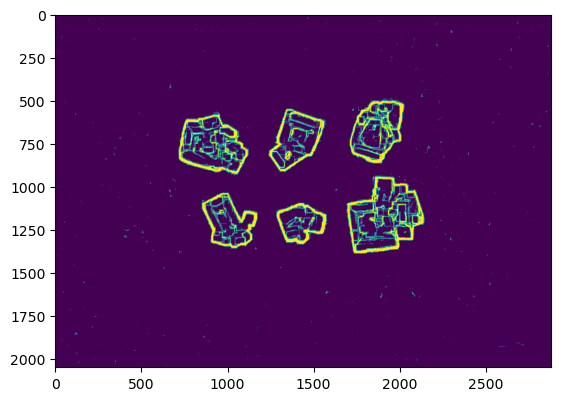

In [415]:
i=37
im = np.load(fpaths_T40[25])
im2=np.load(fpaths_T40[10])
plt.imshow(im+2*im2)

In [421]:
mins = 17#7
sec = 30 #40

totsec = mins*60 + sec
totsec

1050

In [423]:
# Load edge images - 1 every 10 seconds
#tot = len(fpaths_T40)
itest = (np.linspace(460,1050,100)).astype(int)
outline_images = []
for i in itest:
    im = np.load(fpaths_T40[i])
    outline_images.append(im)
    
# Get reference image
imi = np.load(fpaths_T40[460])
imf = np.load(fpaths_T40[1050])
im_test = imi*3+imf

%matplotlib inline
plt.imshow(im_test)

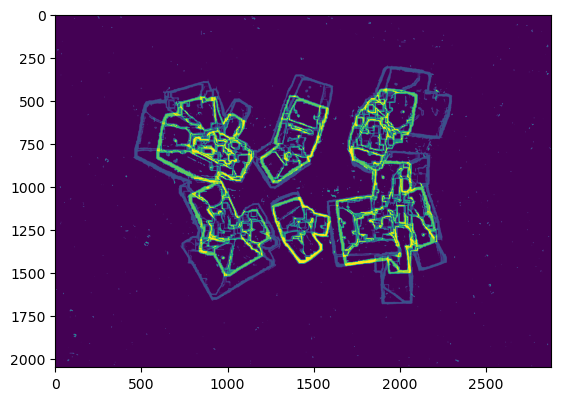

In [505]:
itest = (np.linspace(460,1600,100)).astype(int)
full_im = np.zeros_like(im,dtype=np.float32)
for i in itest:
    im = np.load(fpaths_T40[i])
    #outline_images.append(im)
    # full_im +=im*i
    # full_im[np.where(full_im>i)]=i

    full_im[np.where(full_im == 0)] = im[np.where(full_im == 0)]*(i+1)

In [520]:
np.min(full_im)

0.0

(2000.0, 2500.0, 600.0, 200.0)

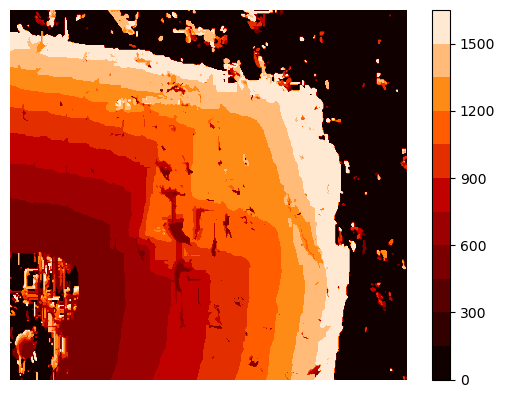

In [530]:
plt.contourf((full_im),levels=10,cmap='gist_heat')
plt.xlim([2000,2500])
plt.ylim([600,200])
plt.colorbar()

plt.axis('off')


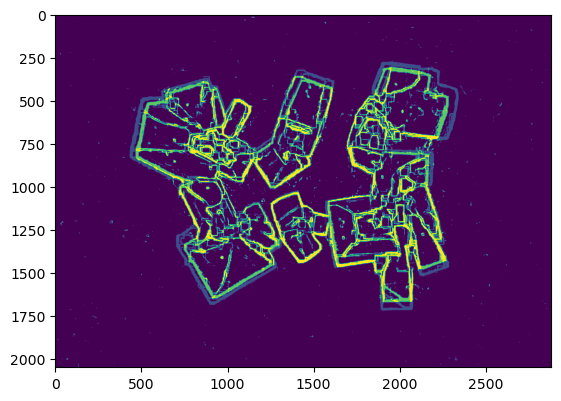

In [587]:
# Load edge images - 1 every 10 seconds
#tot = len(fpaths_T40)
start,stop = 1000,1200
itest = (np.linspace(start,stop,100)).astype(int)
outline_images = []
for i in itest:
    im = np.load(fpaths_T40[i])
    outline_images.append(im)
    
# Get reference image
imi = np.load(fpaths_T40[start])
imf = np.load(fpaths_T40[stop])
im_test = imi*3+imf

%matplotlib inline
plt.imshow(im_test)

In [588]:
# Choose facets

# LABEL CRYSTAL HERE
crystal='7'
%matplotlib qt
line_points_list=(oif.manual_detection(im_test,max_shapes=25))

# calculate average location of all edges
i_edge = np.where(imf!=0)
my,mx = np.mean(i_edge[0]),np.mean(i_edge[1])

dists = []
for i in range(2):
    x,y = line_points_list[i][1]
    d = ((x-mx)**2 + (y-my)**2)**0.5
    dists.append(d)

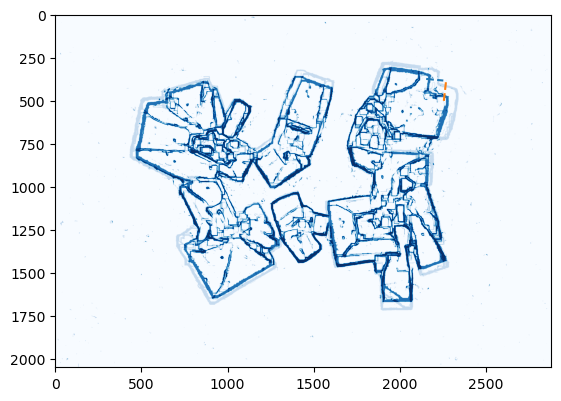

In [589]:
%matplotlib inline
plt.imshow(im_test,cmap='Blues')
for pair in line_points_list:
    plt.plot(pair[:,0],pair[:,1],'--')

In [590]:
%matplotlib inline
pixel_size=scale
# Extract growth profiles
positions_array=[]
error_array = []
for i in np.arange(len(line_points_list)):
    print(i)
    line_points=line_points_list[i]
    positions, error = extract_facet_positions(line_points, outline_images, pixel_size)#,crop_window_width=3,automatic_alignment=False)
    positions_array.append(positions)
    error_array.append(error)
positions_array=np.array(positions_array)
error_array = np.array(error_array)

0
1


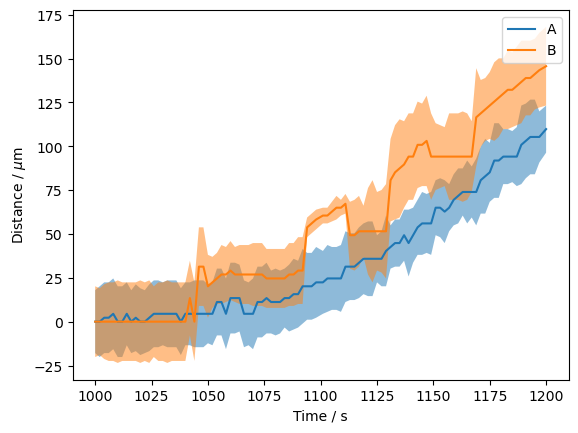

In [591]:
# Check how it looks
%matplotlib inline
labels = ['A','B','C','D']
for i,p in enumerate(positions_array):
    try:
        plt.plot(ts[itest],p,label=labels[i])
        plt.fill_between(ts[itest],p-error_array[i],p+error_array[i],alpha=.5)
    except:
        continue
        
plt.xlabel('Time / s')
plt.ylabel('Distance / $\mu$m')
plt.legend()

In [599]:
start,stop = 460,1600
itest1 = (np.linspace(start,stop,100)).astype(int)

In [538]:
ps1 = positions_array
ts1 = ts
lpl1 = line_points_list

In [598]:
ps2 = positions_array
ts2 = ts
lpl2 = line_points_list
itest2=itest

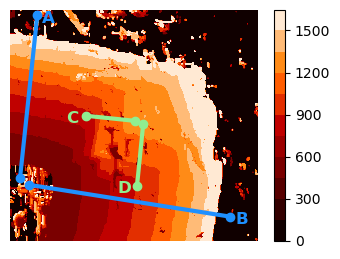

In [694]:
plt.figure(figsize=(4,3))
plt.contourf((full_im),levels=10,cmap='gist_heat')
plt.xlim([2000,2500])
plt.ylim([600,180])
plt.colorbar()

plt.axis('off')

labels = ['A','B']
for i,pair in enumerate(lpl1):
    plt.plot(pair[:,0],pair[:,1],'o-',lw=3,color='dodgerblue')
    plt.text(pair[:,0][1]+10,pair[:,1][1]+12,labels[i],color='dodgerblue',fontweight="bold",fontsize=12)
    
labels = ['C','D']
for i,pair in enumerate(lpl2):
    plt.plot(pair[:,0],pair[:,1],'o-',lw=3,color='lightgreen')
    plt.text(pair[:,0][0]-40,pair[:,1][0]+12,labels[i],color='lightgreen',fontweight="bold",fontsize=12)

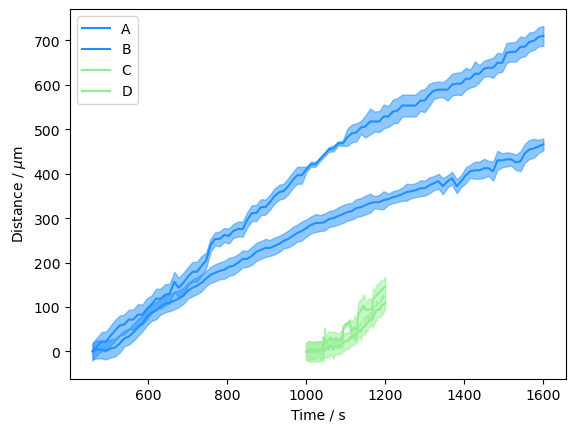

In [672]:
positions_array = ps1
ts = ts1
labels = ['A','B']
itest=itest1
for i,p in enumerate(positions_array):
    try:
        plt.plot(ts[itest],p,label=labels[i],color='dodgerblue')
        plt.fill_between(ts[itest],p-error_array[i],p+error_array[i],alpha=.5,color='dodgerblue')
    except:
        continue
        
positions_array = ps2
ts = ts2
itest=itest2
labels = ['C','D']
for i,p in enumerate(positions_array):
    try:
        plt.plot(ts[itest],p,label=labels[i],color='lightgreen')
        plt.fill_between(ts[itest],p-error_array[i],p+error_array[i],alpha=.5,color='lightgreen')
    except:
        continue
        
plt.xlabel('Time / s')
plt.ylabel('Distance / $\mu$m')
plt.legend()

In [662]:
grada = (ps1[0][-1] - ps1[0][60]) / (itest1[-1]-itest1[60])
gradb = (ps1[1][-1] - ps1[1][60]) / (itest1[-1]-itest1[60])
grada, gradb

(0.30364444444444455, 0.4529777777777777)

In [641]:
1/scale/scale*0.5

0.09964923469387753

In [614]:
gradc = (ps2[0][-1] - ps2[0][10]) / (itest2[-1]-itest2[10])
gradd = (ps2[1][-1] - ps2[1][10]) / (itest2[-1]-itest2[10])
gradc, gradd

(0.6097777777777778, 0.808888888888889)

In [643]:
1/scale/scale*0.8

0.15943877551020405

In [639]:
0.12 +- 0.02

0.09999999999999999

Text(0, 0.5, 'Facet growth rate / $\\mu$m s$^{-1}$')

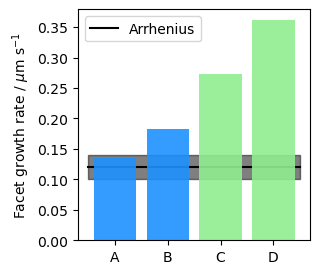

In [690]:

avg = .12
err = 0.02
plt.figure(figsize=(3,3))
plt.fill_between([-.5,3.5],np.array([avg,avg])-err,np.array([avg,avg])+err,color='k',alpha=.5)
plt.plot([-.5,3.5],np.array([avg,avg]),color='k',zorder=-1)
plt.bar(np.arange(2),np.array([grada,gradb*0.9])/scale,alpha=.9,color='dodgerblue')
plt.bar(np.arange(2,4),np.array([gradc,gradd])/scale,alpha=.9,color='lightgreen')
plt.legend(['_nolegend_','Arrhenius'])
plt.xticks([0,1,2,3],['A','B','C','D'])
plt.ylabel(r'Facet growth rate / $\mu$m s$^{-1}$')